In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#!pip install pandas
#!pip install tqdm

#!pip install scipy
#!pip install matchms
#!pip install scikit-learn
#!pip install spec2vec
#!pip install seaborn

In [3]:
import os
os.chdir('/Users/sebas/projects/metabolomics')
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

In [4]:
from src.transformers.sklearn_model import SklearnModel

In [5]:
import gensim
from src.load_data import LoadData
from src.config import Config
from matchms import calculate_scores
from matchms.importing import load_from_mgf,load_from_msp
import matchms.filtering as msfilters
from spec2vec import SpectrumDocument
from spec2vec.model_building import train_new_word2vec_model
from tqdm import tqdm
from src.loader_saver import LoaderSaver
import itertools
import numpy as np
from matchms.importing import load_from_msp
from matchms.similarity import ModifiedCosine
from scipy.stats import spearmanr
import dill
from src.plotting import Plotting
from src.load_data import LoadData
from sklearn.model_selection import train_test_split
from src.train_utils import TrainUtils
from src.preprocessor import Preprocessor
from matchms.filtering import add_fingerprint
import pickle
import sys
from src.config import Config
from src.parser import Parser
from datetime import datetime
from src.loader_saver import LoaderSaver
from src.spec2vec_comparison import Spec2VecComparison
from src.ms2deepscore_comparison import MS2DeepScoreComparison
from src.molecular_pairs_set import MolecularPairsSet
from scipy.stats import spearmanr

In [6]:
from src.transformers.embedder import Embedder

In [7]:
ls /Users/sebas/projects/data

ALL_GNPS_NO_PROPOGATED_wb.mgf
GNPS-NIH-NATURALPRODUCTSLIBRARY.mgf
all_spectrums_gnps.pkl
all_spectrums_gnps_nist_20240130_gnps_nist_janssen.pkl
all_spectrums_janssen.pkl
all_spectrums_nist.pkl
best_model.ckpt
best_model_128n_10_layers_20240209.ckpt
best_model_128n_5_layers_20240219_elementwise.ckpt
best_model_128n_5_layers_20240229.ckpt
best_model_128n_5_layers_20240303.ckpt
best_model_20240301.ckpt
best_model_20240318_lib_cos_sim.ckpt
drug_plus.mgf
hr_msms_nist_all.MSP*
hr_msms_nist_sample.MSP
merged_gnps_nist_20240118_gnps_nist_janssen.pkl
merged_gnps_nist_20240207_gnps_nist_janssen_15_millions.pkl
merged_gnps_nist_20240227_gnps_nist_janssen_20_millions_OUTSIDE_MAX_DIFF_NO_JANSSEN.pkl
merged_gnps_nist_20240311_unique_smiles_1_million.pkl
ms2deepscore_positive_10k_1000_1000_1000_500.hdf5
spec2vec_AllPositive_ratio05_filtered_201101_iter_15.model
spec2vec_AllPositive_ratio05_filtered_201101_iter_15.model.trainables.syn1neg.npy
spec2vec_AllPositive_ratio05_filtered_201101_iter_15.model.

## Parameters

In [8]:
data_folder= '/Users/sebas/projects/data/'
dataset_path = data_folder + 'uniformed_molecule_pairs_test.pkl'
gnps_path =  data_folder + 'ALL_GNPS_NO_PROPOGATED_wb.mgf'
janssen_path = data_folder + 'drug_plus.mgf'
nist_path = data_folder + 'hr_msms_nist_all.MSP'
output_pairs_file= data_folder + 'molecular_pairs.pkl'
output_nist_file= data_folder + 'all_spectrums_nist.pkl'
output_gnps_file= data_folder + 'all_spectrums_gnps.pkl'
output_janssen_file= data_folder + 'all_spectrums_janssen.pkl'
model_spec2vec_file = data_folder + 'spec2vec_AllPositive_ratio05_filtered_201101_iter_15.model'
model_ms2d_file= data_folder + 'ms2deepscore_positive_10k_1000_1000_1000_500.hdf5'
#uniformed_molecule_pairs_test_path= data_folder +'merged_gnps_nist_20240227_gnps_nist_janssen_20_millions_OUTSIDE_MAX_DIFF_NO_JANSSEN.pkl'
uniformed_molecule_pairs_test_path= data_folder +'merged_gnps_nist_20240311_unique_smiles_1_million.pkl'
#transformer_path = data_folder + 'best_model_128n_5_layers_20240219_elementwise.ckpt'
#transformer_path = data_folder + 'best_model_128n_5_layers_20240303.ckpt'
transformer_path = data_folder + 'best_model_20240318_lib_cos_sim.ckpt'

In [9]:
THRESHOLD_ANALOG=0.7

In [12]:
compute_pairs= False
only_use_gnps=False
only_use_janssen=False

In [13]:
## Load spectrum using spectrumutils

In [14]:
config=Config()

## Load data from matchms

In [15]:
all_spectrums_gnps_MATCHMS = [(s) for s in load_from_mgf(gnps_path)]

In [16]:
len(all_spectrums_gnps_MATCHMS)

504840

In [20]:
all_spectrums_nist_MATCHMS = [(s) for s in load_from_msp(nist_path)]

In [21]:
len(all_spectrums_nist_MATCHMS)

1026712

In [22]:
all_spectrums_janssen_MATCHMS = [(s) for s in load_from_mgf(janssen_path)]

2024-03-18 10:25:42,514:WARNING:matchms:add_retention:N/A can't be converted to float.
2024-03-18 10:25:42,515:WARNING:matchms:add_retention:N/A can't be converted to float.
2024-03-18 10:25:42,516:WARNING:matchms:add_retention:N/A can't be converted to float.
2024-03-18 10:25:42,517:WARNING:matchms:add_retention:N/A can't be converted to float.
2024-03-18 10:25:42,517:WARNING:matchms:add_retention:N/A can't be converted to float.
2024-03-18 10:25:42,518:WARNING:matchms:add_retention:N/A can't be converted to float.
2024-03-18 10:25:42,519:WARNING:matchms:add_retention:N/A can't be converted to float.
2024-03-18 10:25:42,519:WARNING:matchms:add_retention:N/A can't be converted to float.
2024-03-18 10:25:42,520:WARNING:matchms:add_retention:N/A can't be converted to float.
2024-03-18 10:25:42,520:WARNING:matchms:add_retention:N/A can't be converted to float.
2024-03-18 10:25:42,521:WARNING:matchms:add_retention:N/A can't be converted to float.
2024-03-18 10:25:42,522:WARNING:matchms:add

In [23]:
#all_spectrums_nist_MATCHMS = list(itertools.islice(load_from_msp(nist_path), 30000))
all_spectrums_nist_MATCHMS = [s for s in load_from_msp(nist_path)]

In [24]:
len(all_spectrums_gnps_MATCHMS),len(all_spectrums_janssen_MATCHMS),len(all_spectrums_nist_MATCHMS)

(504840, 2546, 1026712)

In [25]:
all_spectrums_MATCHMS = all_spectrums_gnps_MATCHMS + all_spectrums_janssen_MATCHMS + all_spectrums_nist_MATCHMS

## Load molecular pairs

In [26]:


with open(uniformed_molecule_pairs_test_path, 'rb') as file:
            dataset = dill.load(file)
original_molecule_pairs= dataset['uniformed_molecule_pairs_test']


In [27]:

if compute_pairs:
        spectrums_janssen = [s for s in original_molecule_pairs.spectrums if s.library=='janssen']
        number_pairs=1000000
        original_molecule_pairs= TrainUtils.compute_all_tanimoto_results(spectrums_janssen, 
                                                                max_combinations=number_pairs, 
                                                                use_tqdm=True, 
                                                                max_mass_diff=config.MAX_MASS_DIFF, 
                                                                min_mass_diff=config.MIN_MASS_DIFF)

In [28]:
len(original_molecule_pairs)

40940

In [29]:
if only_use_gnps:
    molecule_pairs = original_molecule_pairs.get_gnps_pairs()
elif only_use_janssen:
    molecule_pairs = original_molecule_pairs.get_janssen_pairs()
else:
    molecule_pairs=original_molecule_pairs



In [30]:
len(molecule_pairs)

40940

## get the hash indexes in the original datasets

In [31]:
hash_gnps_MATCHMS = [s.spectrum_hash() for s in all_spectrums_gnps_MATCHMS]

In [32]:
hash_janssen_MATCHMS = [s.spectrum_hash() for s in all_spectrums_janssen_MATCHMS]

In [33]:
hash_nist_MATCHMS = [s.spectrum_hash() for s in all_spectrums_nist_MATCHMS]

In [34]:
#compute all the hashes from the datasets
target_hashes = [s.spectrum_hash() for s in all_spectrums_MATCHMS]

In [38]:
spectrums_0, spectrums_1 = original_molecule_pairs.get_sampled_spectrums()

In [41]:
unique_hashes_in_molecule_pairs= np.unique([s.spectrum_hash for s in spectrums_0]+\
                                           [s.spectrum_hash for s in spectrums_1])

In [43]:
# spectrums that are used in my dataset
spectrums_match_hash= [(s,t) for s,t in zip(all_spectrums_MATCHMS, target_hashes) if (t in unique_hashes_in_molecule_pairs)]

In [44]:
original_spectrum_match_hash= [p[0] for p in spectrums_match_hash]
target_hashes_subset = [p[1] for p in spectrums_match_hash]

In [45]:
for i in tqdm(range(len(original_spectrum_match_hash))):
    original_spectrum_match_hash[i] = add_fingerprint(original_spectrum_match_hash[i],
                                             fingerprint_type="daylight", nbits=2048)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3838/3838 [00:05<00:00, 752.95it/s]


## Preprocessing data for spec2vec

In [46]:
preprocessed_spectrums = original_spectrum_match_hash.copy()

In [47]:
for i in tqdm(range(len(original_spectrum_match_hash))):
    preprocessed_spectrums[i] = Spec2VecComparison.spectrum_processing(original_spectrum_match_hash[i])

  1%|██▎                                                                                                                                                                         | 51/3838 [00:00<00:07, 506.49it/s]

2024-03-18 10:45:05,283:WARNING:matchms:interpret_unknown_adduct:Charge was found 0 times in adduct [M+Fe-2H]


  3%|████▉                                                                                                                                                                      | 111/3838 [00:00<00:06, 556.51it/s]

2024-03-18 10:45:05,362:WARNING:matchms:interpret_unknown_adduct:Charge was found 0 times in adduct [M-H2+Fe]


 47%|███████████████████████████████████████████████████████████████████████████████▌                                                                                          | 1795/3838 [00:03<00:03, 608.94it/s]

2024-03-18 10:45:08,213:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-18 10:45:08,213:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-18 10:45:08,214:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-18 10:45:08,214:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-18 10:45:08,215:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-18 10:45:08,215:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-18 10:45:08,216:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 48%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                       | 1856/3838 [00:03<00:03, 532.43it/s]

2024-03-18 10:45:08,362:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-18 10:45:08,363:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-18 10:45:08,365:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-18 10:45:08,365:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-18 10:45:08,368:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-18 10:45:08,368:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-18 10:45:08,371:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 50%|████████████████████████████████████████████████████████████████████████████████████▋                                                                                     | 1911/3838 [00:03<00:04, 449.75it/s]

2024-03-18 10:45:08,534:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-18 10:45:08,534:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-18 10:45:08,537:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-18 10:45:08,537:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-18 10:45:08,540:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-18 10:45:08,540:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-18 10:45:08,543:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 51%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                                   | 1960/3838 [00:03<00:04, 413.81it/s]

2024-03-18 10:45:08,680:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-18 10:45:08,680:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-18 10:45:08,683:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-18 10:45:08,683:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-18 10:45:08,686:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-18 10:45:08,686:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-18 10:45:08,689:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 52%|████████████████████████████████████████████████████████████████████████████████████████▊                                                                                 | 2004/3838 [00:03<00:04, 403.43it/s]

2024-03-18 10:45:08,797:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-18 10:45:08,797:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-18 10:45:08,799:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-18 10:45:08,799:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-18 10:45:08,801:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-18 10:45:08,801:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-18 10:45:08,803:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 53%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 2046/3838 [00:03<00:04, 383.40it/s]

2024-03-18 10:45:08,922:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-18 10:45:08,922:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-18 10:45:08,924:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-18 10:45:08,924:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-18 10:45:08,927:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-18 10:45:08,927:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-18 10:45:08,930:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 54%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 2086/3838 [00:03<00:04, 380.42it/s]

2024-03-18 10:45:09,029:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-18 10:45:09,030:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-18 10:45:09,032:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-18 10:45:09,032:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-18 10:45:09,035:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-18 10:45:09,036:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-18 10:45:09,038:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 55%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                            | 2125/3838 [00:04<00:04, 355.01it/s]

2024-03-18 10:45:09,160:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-18 10:45:09,160:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-18 10:45:09,162:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-18 10:45:09,162:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-18 10:45:09,164:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-18 10:45:09,164:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-18 10:45:09,166:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 56%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                                          | 2162/3838 [00:04<00:04, 357.85it/s]

2024-03-18 10:45:09,261:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-18 10:45:09,261:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-18 10:45:09,265:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-18 10:45:09,265:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-18 10:45:09,267:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-18 10:45:09,268:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-18 10:45:09,270:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 57%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 2200/3838 [00:04<00:04, 357.56it/s]

2024-03-18 10:45:09,368:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-18 10:45:09,368:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-18 10:45:09,371:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-18 10:45:09,371:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-18 10:45:09,374:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-18 10:45:09,374:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-18 10:45:09,377:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 58%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 2237/3838 [00:04<00:04, 358.17it/s]

2024-03-18 10:45:09,470:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-18 10:45:09,471:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-18 10:45:09,473:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-18 10:45:09,473:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-18 10:45:09,475:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-18 10:45:09,475:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-18 10:45:09,479:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 59%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 2274/3838 [00:04<00:04, 361.37it/s]

2024-03-18 10:45:09,571:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-18 10:45:09,571:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-18 10:45:09,574:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-18 10:45:09,574:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-18 10:45:09,576:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-18 10:45:09,577:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-18 10:45:09,579:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 2311/3838 [00:04<00:04, 332.64it/s]

2024-03-18 10:45:09,703:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-18 10:45:09,703:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-18 10:45:09,705:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-18 10:45:09,706:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-18 10:45:09,708:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-18 10:45:09,708:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-18 10:45:09,711:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 2353/3838 [00:04<00:04, 352.36it/s]

2024-03-18 10:45:09,808:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-18 10:45:09,808:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-18 10:45:09,811:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-18 10:45:09,811:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-18 10:45:09,816:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-18 10:45:09,816:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-18 10:45:09,823:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                | 2389/3838 [00:04<00:04, 336.91it/s]

2024-03-18 10:45:09,926:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-18 10:45:09,927:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-18 10:45:09,929:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-18 10:45:09,929:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-18 10:45:09,931:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-18 10:45:09,931:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-18 10:45:09,933:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 2425/3838 [00:04<00:04, 343.21it/s]

2024-03-18 10:45:10,026:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-18 10:45:10,027:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-18 10:45:10,030:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-18 10:45:10,030:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-18 10:45:10,033:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-18 10:45:10,033:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-18 10:45:10,036:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 2460/3838 [00:05<00:04, 319.97it/s]

2024-03-18 10:45:10,154:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-18 10:45:10,155:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-18 10:45:10,157:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-18 10:45:10,157:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-18 10:45:10,160:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-18 10:45:10,160:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-18 10:45:10,162:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 2499/3838 [00:05<00:03, 338.70it/s]

2024-03-18 10:45:10,255:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-18 10:45:10,255:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-18 10:45:10,257:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-18 10:45:10,258:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-18 10:45:10,261:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-18 10:45:10,261:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-18 10:45:10,265:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 2534/3838 [00:05<00:03, 338.30it/s]

2024-03-18 10:45:10,358:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-18 10:45:10,359:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-18 10:45:10,361:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-18 10:45:10,361:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-18 10:45:10,363:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-18 10:45:10,363:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-18 10:45:10,366:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 2573/3838 [00:05<00:03, 351.62it/s]

2024-03-18 10:45:10,460:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-18 10:45:10,460:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-18 10:45:10,462:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-18 10:45:10,462:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-18 10:45:10,464:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-18 10:45:10,464:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-18 10:45:10,466:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 2614/3838 [00:05<00:03, 367.70it/s]

2024-03-18 10:45:10,560:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-18 10:45:10,560:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-18 10:45:10,563:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-18 10:45:10,563:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-18 10:45:10,565:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-18 10:45:10,565:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-18 10:45:10,568:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 2652/3838 [00:05<00:03, 339.26it/s]

2024-03-18 10:45:10,693:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-18 10:45:10,693:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-18 10:45:10,695:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-18 10:45:10,695:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-18 10:45:10,697:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-18 10:45:10,698:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-18 10:45:10,700:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 2694/3838 [00:05<00:03, 359.09it/s]

2024-03-18 10:45:10,795:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-18 10:45:10,796:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-18 10:45:10,798:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-18 10:45:10,798:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-18 10:45:10,801:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-18 10:45:10,801:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-18 10:45:10,803:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 2734/3838 [00:05<00:02, 368.64it/s]

2024-03-18 10:45:10,897:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-18 10:45:10,897:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-18 10:45:10,899:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-18 10:45:10,900:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-18 10:45:10,902:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-18 10:45:10,902:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-18 10:45:10,904:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 2774/3838 [00:05<00:02, 377.48it/s]

2024-03-18 10:45:10,997:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-18 10:45:10,997:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-18 10:45:10,999:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-18 10:45:10,999:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-18 10:45:11,001:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-18 10:45:11,001:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-18 10:45:11,004:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 2813/3838 [00:06<00:03, 337.69it/s]

2024-03-18 10:45:11,141:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-18 10:45:11,143:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-18 10:45:11,144:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-18 10:45:11,146:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-18 10:45:11,147:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-18 10:45:11,148:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-18 10:45:11,150:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 2848/3838 [00:06<00:03, 329.96it/s]

2024-03-18 10:45:11,254:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-18 10:45:11,255:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-18 10:45:11,257:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-18 10:45:11,257:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-18 10:45:11,260:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-18 10:45:11,260:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-18 10:45:11,262:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 2885/3838 [00:06<00:02, 340.25it/s]

2024-03-18 10:45:11,355:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-18 10:45:11,355:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-18 10:45:11,358:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-18 10:45:11,359:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-18 10:45:11,361:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-18 10:45:11,361:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-18 10:45:11,363:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 2927/3838 [00:06<00:02, 362.43it/s]

2024-03-18 10:45:11,454:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-18 10:45:11,455:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-18 10:45:11,457:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-18 10:45:11,457:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-18 10:45:11,461:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-18 10:45:11,461:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-18 10:45:11,463:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 2965/3838 [00:06<00:02, 366.22it/s]

2024-03-18 10:45:11,556:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-18 10:45:11,556:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-18 10:45:11,559:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-18 10:45:11,560:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-18 10:45:11,562:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-18 10:45:11,563:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-18 10:45:11,565:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 3003/3838 [00:06<00:02, 368.97it/s]

2024-03-18 10:45:11,657:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-18 10:45:11,657:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-18 10:45:11,659:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-18 10:45:11,659:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-18 10:45:11,661:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-18 10:45:11,661:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-18 10:45:11,663:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 3048/3838 [00:06<00:02, 392.51it/s]

2024-03-18 10:45:11,757:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-18 10:45:11,757:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-18 10:45:11,760:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-18 10:45:11,760:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-18 10:45:11,762:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-18 10:45:11,762:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-18 10:45:11,764:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 3088/3838 [00:06<00:01, 384.28it/s]

2024-03-18 10:45:11,866:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-18 10:45:11,867:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-18 10:45:11,869:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-18 10:45:11,869:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-18 10:45:11,871:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-18 10:45:11,871:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-18 10:45:11,873:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 3127/3838 [00:06<00:01, 375.30it/s]

2024-03-18 10:45:11,976:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-18 10:45:11,977:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-18 10:45:11,980:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-18 10:45:11,980:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-18 10:45:11,982:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-18 10:45:11,982:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-18 10:45:11,985:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 3166/3838 [00:06<00:01, 377.22it/s]

2024-03-18 10:45:12,078:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-18 10:45:12,078:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-18 10:45:12,080:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-18 10:45:12,080:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-18 10:45:12,082:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-18 10:45:12,082:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-18 10:45:12,084:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 3210/3838 [00:07<00:01, 393.93it/s]

2024-03-18 10:45:12,179:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-18 10:45:12,179:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-18 10:45:12,181:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-18 10:45:12,181:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-18 10:45:12,184:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-18 10:45:12,184:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-18 10:45:12,186:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 3253/3838 [00:07<00:01, 402.49it/s]

2024-03-18 10:45:12,281:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-18 10:45:12,282:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-18 10:45:12,285:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-18 10:45:12,285:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-18 10:45:12,287:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-18 10:45:12,288:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-18 10:45:12,290:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 3294/3838 [00:07<00:01, 364.79it/s]

2024-03-18 10:45:12,418:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-18 10:45:12,418:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-18 10:45:12,420:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-18 10:45:12,421:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-18 10:45:12,423:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-18 10:45:12,423:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-18 10:45:12,425:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 3336/3838 [00:07<00:01, 377.96it/s]

2024-03-18 10:45:12,520:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-18 10:45:12,520:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-18 10:45:12,522:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-18 10:45:12,523:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-18 10:45:12,525:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-18 10:45:12,526:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-18 10:45:12,528:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 3377/3838 [00:07<00:01, 386.41it/s]

2024-03-18 10:45:12,621:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-18 10:45:12,621:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-18 10:45:12,624:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-18 10:45:12,624:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-18 10:45:12,626:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-18 10:45:12,627:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-18 10:45:12,629:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 3419/3838 [00:07<00:01, 395.39it/s]

2024-03-18 10:45:12,721:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-18 10:45:12,721:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-18 10:45:12,723:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-18 10:45:12,724:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-18 10:45:12,725:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-18 10:45:12,725:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-18 10:45:12,727:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 3459/3838 [00:07<00:01, 370.26it/s]

2024-03-18 10:45:12,846:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-18 10:45:12,846:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-18 10:45:12,848:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-18 10:45:12,848:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-18 10:45:12,850:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-18 10:45:12,850:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-18 10:45:12,852:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 3497/3838 [00:07<00:00, 372.95it/s]

2024-03-18 10:45:12,946:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-18 10:45:12,946:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-18 10:45:12,948:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-18 10:45:12,948:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-18 10:45:12,951:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-18 10:45:12,951:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-18 10:45:12,953:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 3535/3838 [00:07<00:00, 354.45it/s]

2024-03-18 10:45:13,066:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-18 10:45:13,066:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-18 10:45:13,069:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-18 10:45:13,069:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-18 10:45:13,071:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-18 10:45:13,071:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-18 10:45:13,074:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 3575/3838 [00:08<00:00, 366.10it/s]

2024-03-18 10:45:13,167:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-18 10:45:13,167:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-18 10:45:13,169:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-18 10:45:13,170:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-18 10:45:13,172:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-18 10:45:13,172:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-18 10:45:13,174:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 3612/3838 [00:08<00:00, 342.35it/s]

2024-03-18 10:45:13,293:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-18 10:45:13,293:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-18 10:45:13,295:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-18 10:45:13,295:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-18 10:45:13,297:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-18 10:45:13,297:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-18 10:45:13,299:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 3655/3838 [00:08<00:00, 366.30it/s]

2024-03-18 10:45:13,393:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-18 10:45:13,393:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-18 10:45:13,395:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-18 10:45:13,395:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-18 10:45:13,398:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-18 10:45:13,398:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-18 10:45:13,400:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 3699/3838 [00:08<00:00, 384.21it/s]

2024-03-18 10:45:13,496:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-18 10:45:13,496:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-18 10:45:13,498:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-18 10:45:13,498:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-18 10:45:13,501:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-18 10:45:13,501:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-18 10:45:13,504:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 3739/3838 [00:08<00:00, 386.73it/s]

2024-03-18 10:45:13,597:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-18 10:45:13,598:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-18 10:45:13,602:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-18 10:45:13,602:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-18 10:45:13,605:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-18 10:45:13,605:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-18 10:45:13,607:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 3779/3838 [00:08<00:00, 360.65it/s]

2024-03-18 10:45:13,726:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-18 10:45:13,726:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-18 10:45:13,729:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-18 10:45:13,730:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-18 10:45:13,732:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-18 10:45:13,732:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-18 10:45:13,735:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 3816/3838 [00:08<00:00, 359.38it/s]

2024-03-18 10:45:13,830:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-18 10:45:13,831:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-18 10:45:13,835:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-18 10:45:13,835:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-18 10:45:13,838:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-18 10:45:13,840:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-18 10:45:13,843:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3838/3838 [00:08<00:00, 437.87it/s]


In [48]:
for i in tqdm(range(len(preprocessed_spectrums))):
    preprocessed_spectrums[i] = add_fingerprint(preprocessed_spectrums[i],
                                             fingerprint_type="daylight", nbits=2048)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3838/3838 [00:04<00:00, 798.67it/s]


In [49]:
len(preprocessed_spectrums)

3838

##  spec2vec model

In [50]:
spec2vec_similarity =Spec2VecComparison.get_spec2vec_similarity(model_spec2vec_file)

In [67]:
preprocessed_spectrums[0].spectrum_hash

<bound method Spectrum.spectrum_hash of Spectrum(precursor m/z=940.25, 335 fragments between 278.0 and 940.9)>

In [68]:
original_spectrum_match_hash[0].spectrum_hash()

'256b48e5f95e8c19c4f2'

In [69]:
target_hashes_subset[0]

'256b48e5f95e8c19c4f2'

In [70]:
tanimoto_spec2vec, scores_spec2vec= Spec2VecComparison.compute_scores_tanimoto(molecule_pairs, 
                                                                                preprocessed_spectrums, 
                                                                               target_hashes_subset, 
                                                                               spec2vec_similarity)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40940/40940 [00:36<00:00, 1132.23it/s]


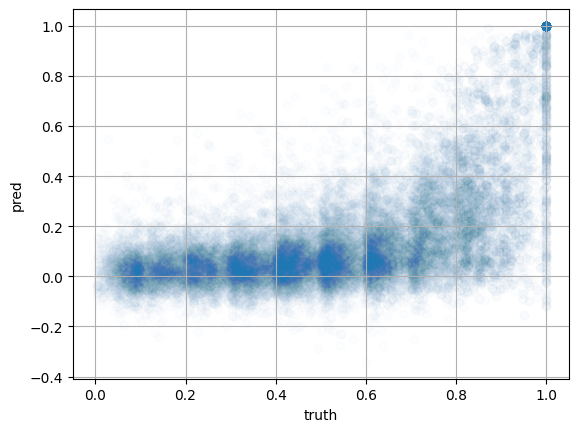

In [71]:
import matplotlib.pyplot as plt
plt.scatter(tanimoto_spec2vec, scores_spec2vec, alpha=0.01)
plt.ylabel('pred')
plt.xlabel('truth')
plt.grid()

In [72]:
original_tanimoto_spec2vec = tanimoto_spec2vec.copy()
original_scores_spec2vec=scores_spec2vec.copy()

In [73]:
tanimoto_spec2vec = [t for t in tanimoto_spec2vec if t is not None]
scores_spec2vec = [t for t in scores_spec2vec if t is not None]

In [74]:
tanimoto_spec2vec_binary=[1 if t>THRESHOLD_ANALOG else 0 for t in tanimoto_spec2vec]
scores_spec2vec= [s if s>0 else 0 for s in scores_spec2vec ]

tpr: [0.         0.15072317 0.15097691 ... 0.94912459 0.94912459 1.        ]
fpr: [0.         0.         0.         ... 0.76254268 0.76260835 1.        ]


(array([0.        , 0.15072317, 0.15097691, ..., 0.94912459, 0.94912459,
        1.        ]),
 array([0.        , 0.        , 0.        , ..., 0.76254268, 0.76260835,
        1.        ]))

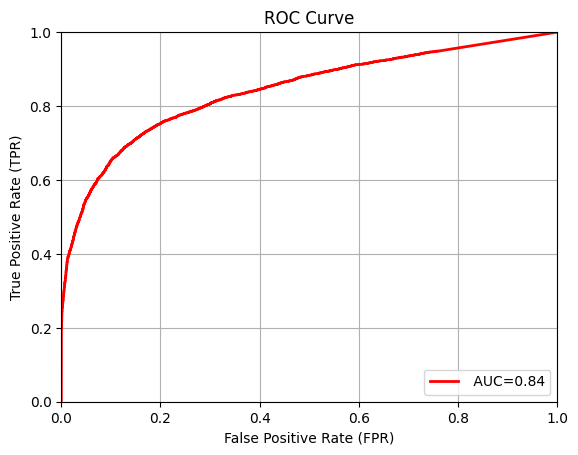

In [75]:
Plotting.plot_roc_curve(tanimoto_spec2vec_binary, 
                        scores_spec2vec)

In [76]:
spearman_spec2vec = spearmanr(tanimoto_spec2vec, scores_spec2vec)

## MS2DEEPSCORE

In [181]:
similarity_ms2 = MS2DeepScoreComparison.get_ms2deepscore_similarity(model_ms2d_file)

In [182]:
random_molecule_pairs_indexes = np.random.choice(range(0,len(molecule_pairs)), size=1000)

In [183]:
random_molecule_pairs_indexes[0]

7667

In [184]:
import tensorflow as tf
from datetime import datetime
start =datetime.now()
with tf.device('/device:CPU:0'):
    tanimotos_ms2, scores_ms2 = MS2DeepScoreComparison.compute_ms2deepscore(molecule_pairs, 
                        random_molecule_pairs_indexes, 
                        original_spectrum_match_hash, 
                        target_hashes_subset,
                        similarity_ms2)
end = datetime.now()

print(f'total seconds {(end-start).total_seconds()}')


  0%|                                                                                                                                                                                      | 0/1000 [00:00<?, ?it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3533.53it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1795.51it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 14ms/step





Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5440.08it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17189.77it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14563.56it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 33288.13it/s]

1/1 [==============================] - 0s 12ms/step




  0%|▎                                                                                                                                                                             | 2/1000 [00:00<01:19, 12.63it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2659.67it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9709.04it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10131.17it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 14ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3761.71it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5825.42it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15477.14it/s]

1/1 [==============================] - 0s 11ms/step




  0%|▋                                                                                                                                                                             | 4/1000 [00:00<01:03, 15.67it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4655.17it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2849.39it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5526.09it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11008.67it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5077.85it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10407.70it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step



  1%|█                                                                                                                                                                             | 6/1000 [00:00<00:59, 16.84it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6462.72it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9986.44it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12520.31it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8322.03it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16980.99it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3862.16it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12633.45it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8612.53it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21845.33it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10894.30it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17848.10it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step



  1%|█▌                                                                                                                                                                            | 9/1000 [00:00<00:54, 18.30it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6326.25it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17189.77it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5178.15it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4369.07it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12018.06it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4505.16it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14926.35it/s]

1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 12ms/step



  1%|█▉                                                                                                                                                                           | 11/1000 [00:00<00:53, 18.54it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 952.39it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4505.16it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3609.56it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9157.87it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15887.52it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9776.93it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step



  1%|██▏                                                                                                                                                                          | 13/1000 [00:00<00:54, 18.01it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3688.92it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10330.80it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11125.47it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 970.90it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5398.07it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7002.18it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16448.25it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 12ms/step



  2%|██▌                                                                                                                                                                          | 15/1000 [00:00<00:53, 18.31it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3187.16it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10512.04it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4629.47it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16644.06it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12192.74it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25115.59it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9078.58it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16070.13it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4544.21it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5029.14it/s]

1/1 [==============================] - 0s 12ms/step




  2%|███                                                                                                                                                                          | 18/1000 [00:00<00:51, 19.07it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5849.80it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9986.44it/s]


Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 442.48it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 13ms/step





Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7358.43it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14074.85it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4544.21it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13189.64it/s]


1/1 [==============================] - 0s 12ms/step



  2%|███▍                                                                                                                                                                         | 20/1000 [00:01<00:50, 19.23it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1807.89it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9425.40it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 10ms/step





Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3236.35it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12372.58it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11125.47it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19152.07it/s]


1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8128.50it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18315.74it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]


1/1 [==============================] - 0s 12ms/step



  2%|███▉                                                                                                                                                                         | 23/1000 [00:01<00:49, 19.80it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7639.90it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9078.58it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7037.42it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5102.56it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17623.13it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4922.89it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10205.12it/s]


1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17549.39it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2197.12it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10180.35it/s]


1/1 [==============================] - 0s 11ms/step



  3%|████▍                                                                                                                                                                        | 26/1000 [00:01<00:48, 20.11it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8630.26it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12985.46it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3622.02it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14074.85it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4544.21it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15887.52it/s]


1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17260.51it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6574.14it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22795.13it/s]


1/1 [==============================] - 0s 11ms/step



  3%|█████                                                                                                                                                                        | 29/1000 [00:01<00:47, 20.37it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7463.17it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8322.03it/s]


Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 972.71it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1841.22it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7626.01it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11366.68it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]


1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9822.73it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4539.29it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15141.89it/s]


1/1 [==============================] - 0s 11ms/step



  3%|█████▌                                                                                                                                                                       | 32/1000 [00:01<00:47, 20.48it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19878.22it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13148.29it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4544.21it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14122.24it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2908.67it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11881.88it/s]


1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7133.17it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15592.21it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16644.06it/s]


1/1 [==============================] - 0s 11ms/step



  4%|██████                                                                                                                                                                       | 35/1000 [00:01<00:46, 20.74it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4346.43it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6096.37it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9078.58it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6710.89it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10330.80it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13025.79it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16912.52it/s]


1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 255.61it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1987.82it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7244.05it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8272.79it/s]


1/1 [==============================] - 0s 10ms/step



  4%|██████▌                                                                                                                                                                      | 38/1000 [00:01<00:46, 20.60it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8943.08it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17848.10it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1565.04it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6213.78it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15363.75it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13888.42it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]


1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4529.49it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13706.88it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7695.97it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]


1/1 [==============================] - 0s 12ms/step



  4%|███████                                                                                                                                                                      | 41/1000 [00:02<00:46, 20.84it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8630.26it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17549.39it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6364.65it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6615.62it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13315.25it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5785.25it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12157.40it/s]


1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6765.01it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16644.06it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8112.77it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16912.52it/s]


1/1 [==============================] - 0s 12ms/step



  4%|███████▌                                                                                                                                                                     | 44/1000 [00:02<00:45, 20.87it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5349.88it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13530.01it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3495.25it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5236.33it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15887.52it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4116.10it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12372.58it/s]


1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9020.01it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14716.86it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1101.45it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4928.68it/s]


1/1 [==============================] - 0s 11ms/step



  5%|████████▏                                                                                                                                                                    | 47/1000 [00:02<00:46, 20.68it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14266.34it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11748.75it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3477.86it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11618.57it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11366.68it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]


1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5468.45it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13486.51it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6413.31it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14513.16it/s]


1/1 [==============================] - 0s 12ms/step



  5%|████████▋                                                                                                                                                                    | 50/1000 [00:02<00:45, 20.67it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7516.67it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12052.60it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15141.89it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 737.91it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5991.86it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1988.76it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9425.40it/s]


1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8774.69it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16578.28it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5489.93it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15887.52it/s]


1/1 [==============================] - 0s 12ms/step



  5%|█████████▏                                                                                                                                                                   | 53/1000 [00:02<00:45, 20.74it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5475.59it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8867.45it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14926.35it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5071.71it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11781.75it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]


1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6017.65it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6250.83it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11491.24it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24528.09it/s]


1/1 [==============================] - 0s 13ms/step



  6%|█████████▋                                                                                                                                                                   | 56/1000 [00:02<00:45, 20.70it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9799.78it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14315.03it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13315.25it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1039.48it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6213.78it/s]


1/1 [==============================] - 0s 15ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4253.86it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7423.55it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6657.63it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9000.65it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step



  6%|██████████▏                                                                                                                                                                  | 59/1000 [00:02<00:46, 20.16it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5924.16it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16644.06it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13315.25it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9510.89it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17476.27it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9915.61it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11748.75it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3938.31it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11491.24it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17189.77it/s]

1/1 [==============================] - 0s 11ms/step




  6%|██████████▋                                                                                                                                                                  | 62/1000 [00:03<00:45, 20.47it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10645.44it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4002.20it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 900.07it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4826.59it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1496.90it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5841.65it/s]


1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9157.87it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14513.16it/s]


Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 250.62it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1653.25it/s]


1/1 [==============================] - 0s 10ms/step



  6%|███████████▏                                                                                                                                                                 | 65/1000 [00:03<00:45, 20.41it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4544.21it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11618.57it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9078.58it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17549.39it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12052.60it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13315.25it/s]


1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19691.57it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7397.36it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]


1/1 [==============================] - 0s 12ms/step



  7%|███████████▊                                                                                                                                                                 | 68/1000 [00:03<00:45, 20.33it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8701.88it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12483.05it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14217.98it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7810.62it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9709.04it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14122.24it/s]


1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1675.04it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7626.01it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3495.25it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10106.76it/s]


1/1 [==============================] - 0s 12ms/step



  7%|████████████▎                                                                                                                                                                | 71/1000 [00:03<00:45, 20.41it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9892.23it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11748.75it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6710.89it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5614.86it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17189.77it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12372.58it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25575.02it/s]


1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6052.39it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13706.88it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21183.35it/s]


1/1 [==============================] - 0s 11ms/step



  7%|████████████▊                                                                                                                                                                | 74/1000 [00:03<00:44, 20.63it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8473.34it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7397.36it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13148.29it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5102.56it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13315.25it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7145.32it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16131.94it/s]


1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8943.08it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18477.11it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12300.01it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22310.13it/s]


1/1 [==============================] - 0s 12ms/step



  8%|█████████████▎                                                                                                                                                               | 77/1000 [00:03<00:44, 20.77it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 641.82it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3971.88it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8004.40it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12826.62it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9198.04it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13706.88it/s]


1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5706.54it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12336.19it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13025.79it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]


1/1 [==============================] - 0s 13ms/step



  8%|█████████████▊                                                                                                                                                               | 80/1000 [00:04<00:44, 20.62it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1925.76it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7869.24it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4181.76it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3300.00it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14926.35it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6898.53it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17549.39it/s]


1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7332.70it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16980.99it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6026.30it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12787.51it/s]


1/1 [==============================] - 0s 12ms/step



  8%|██████████████▎                                                                                                                                                              | 83/1000 [00:04<00:44, 20.55it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5497.12it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14513.16it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13315.25it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8542.37it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15196.75it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]


1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10230.01it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17260.51it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12985.46it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20360.70it/s]


1/1 [==============================] - 0s 11ms/step



  9%|██████████████▉                                                                                                                                                              | 86/1000 [00:04<00:44, 20.74it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4804.47it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13530.01it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9098.27it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9446.63it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9776.93it/s]


1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13357.66it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21399.51it/s]


1/1 [==============================] - 0s 11ms/step



  9%|███████████████▍                                                                                                                                                             | 89/1000 [00:04<00:43, 20.96it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6710.89it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18558.87it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11491.24it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 13ms/step




Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10082.46it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11491.24it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16644.06it/s]


1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8473.34it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16448.25it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2304.56it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9799.78it/s]


1/1 [==============================] - 0s 11ms/step



  9%|███████████████▉                                                                                                                                                             | 92/1000 [00:04<00:43, 20.90it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8924.05it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18558.87it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10538.45it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5777.28it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16070.13it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3968.12it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11491.24it/s]


1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3938.31it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11915.64it/s]


Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 223.66it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3618.90it/s]


1/1 [==============================] - 0s 12ms/step



 10%|████████████████▍                                                                                                                                                            | 95/1000 [00:04<00:43, 20.62it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1594.19it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8256.50it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1218.21it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8272.79it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13315.25it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6710.89it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16070.13it/s]


1/1 [==============================] - 0s 13ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3506.94it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6932.73it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5785.25it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

1/1 [==============================] - 0s 11ms/step




 10%|████████████████▉                                                                                                                                                            | 98/1000 [00:04<00:43, 20.57it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 196.51it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2115.13it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10866.07it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 12ms/step





Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9619.96it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16912.52it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10407.70it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15141.89it/s]


1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5949.37it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15887.52it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4236.67it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14873.42it/s]


1/1 [==============================] - 0s 11ms/step



 10%|█████████████████▎                                                                                                                                                          | 101/1000 [00:05<00:44, 20.40it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8924.05it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12483.05it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6132.02it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16384.00it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9597.95it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]


1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9000.65it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13888.42it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12985.46it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17848.10it/s]


1/1 [==============================] - 0s 10ms/step



 10%|█████████████████▉                                                                                                                                                          | 104/1000 [00:05<00:43, 20.57it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7194.35it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10979.85it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8004.40it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7358.43it/s]


Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 222.07it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2286.97it/s]


1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1166.70it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5706.54it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3057.07it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11848.32it/s]


1/1 [==============================] - 0s 12ms/step



 11%|██████████████████▍                                                                                                                                                         | 107/1000 [00:05<00:43, 20.44it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6168.09it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8701.88it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11781.75it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 13ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6017.65it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16644.06it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14027.77it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]


1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6502.80it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17331.83it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8701.88it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17189.77it/s]


1/1 [==============================] - 0s 11ms/step



 11%|██████████████████▉                                                                                                                                                         | 110/1000 [00:05<00:43, 20.42it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8081.51it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7639.90it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10512.04it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9709.04it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7584.64it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]


1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15196.75it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10131.17it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16912.52it/s]


1/1 [==============================] - 0s 11ms/step



 11%|███████████████████▍                                                                                                                                                        | 113/1000 [00:05<00:43, 20.61it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9177.91it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14665.40it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11781.75it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3334.10it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13530.01it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11683.30it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21399.51it/s]


1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 719.56it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4080.06it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12633.45it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16644.06it/s]


1/1 [==============================] - 0s 11ms/step



 12%|███████████████████▉                                                                                                                                                        | 116/1000 [00:05<00:42, 20.64it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9157.87it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18558.87it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11881.88it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8112.77it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14716.86it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]


1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1979.38it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9619.96it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3050.40it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11125.47it/s]


1/1 [==============================] - 0s 10ms/step



 12%|████████████████████▍                                                                                                                                                       | 119/1000 [00:05<00:42, 20.95it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8943.08it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16912.52it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1133.29it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5652.70it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17549.39it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14266.34it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27776.85it/s]


1/1 [==============================] - 0s 10ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6061.13it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17848.10it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4346.43it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16194.22it/s]


1/1 [==============================] - 0s 12ms/step



 12%|████████████████████▉                                                                                                                                                       | 122/1000 [00:06<00:41, 20.94it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8128.50it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15363.75it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10866.07it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 10ms/step




Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10512.04it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17772.47it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11491.24it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26886.56it/s]


1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7695.97it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14665.40it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2654.62it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10894.30it/s]


1/1 [==============================] - 0s 11ms/step



 12%|█████████████████████▌                                                                                                                                                      | 125/1000 [00:06<00:41, 21.05it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7557.30it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5683.34it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8848.74it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5405.03it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11748.75it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5489.93it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12671.61it/s]


1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9822.73it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19878.22it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6492.73it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15141.89it/s]


1/1 [==============================] - 0s 11ms/step



 13%|██████████████████████                                                                                                                                                      | 128/1000 [00:06<00:41, 21.07it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1632.02it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7639.90it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11491.24it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7869.24it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17549.39it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10645.44it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]


1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9000.65it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12052.60it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]


1/1 [==============================] - 0s 11ms/step



 13%|██████████████████████▌                                                                                                                                                     | 131/1000 [00:06<00:41, 20.91it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6853.44it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11335.96it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6132.02it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15827.56it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3449.26it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13706.88it/s]


1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9425.40it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16448.25it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6853.44it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15196.75it/s]


1/1 [==============================] - 0s 12ms/step



 13%|███████████████████████                                                                                                                                                     | 134/1000 [00:06<00:41, 20.91it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9986.44it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12985.46it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8612.53it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19691.57it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7294.44it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15420.24it/s]


1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6853.44it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25115.59it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13486.51it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18558.87it/s]


1/1 [==============================] - 0s 11ms/step



 14%|███████████████████████▌                                                                                                                                                    | 137/1000 [00:06<00:41, 20.75it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7752.87it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7037.42it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12520.31it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5825.42it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16912.52it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10866.07it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16980.99it/s]


1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8793.09it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16710.37it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11491.24it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16710.37it/s]


1/1 [==============================] - 0s 12ms/step



 14%|████████████████████████                                                                                                                                                    | 140/1000 [00:06<00:41, 20.79it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6533.18it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8774.69it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17189.77it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12052.60it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17848.10it/s]


1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 519.23it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3675.99it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13148.29it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]


1/1 [==============================] - 0s 11ms/step



 14%|████████████████████████▌                                                                                                                                                   | 143/1000 [00:07<00:41, 20.60it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5440.08it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4782.56it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13530.01it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14315.03it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17549.39it/s]


1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2888.64it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6853.44it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1329.84it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6626.07it/s]

1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 12ms/step



 15%|█████████████████████████                                                                                                                                                   | 146/1000 [00:07<00:42, 20.11it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10106.76it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15363.75it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10645.44it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4804.47it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12520.31it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1626.33it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7307.15it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5152.71it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10433.59it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14266.34it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18808.54it/s]

1/1 [==============================] - 0s 12ms/step




 15%|█████████████████████████▋                                                                                                                                                  | 149/1000 [00:07<00:42, 20.21it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16710.37it/s]


Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 794.83it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8542.37it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15592.21it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12372.58it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13706.88it/s]


1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2045.00it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8338.58it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8338.58it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]


1/1 [==============================] - 0s 11ms/step



 15%|██████████████████████████▏                                                                                                                                                 | 152/1000 [00:07<00:41, 20.29it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6413.31it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8559.80it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11335.96it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9619.96it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17260.51it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9892.23it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15592.21it/s]


1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5236.33it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12520.31it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8388.61it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13486.51it/s]


1/1 [==============================] - 0s 11ms/step



 16%|██████████████████████████▋                                                                                                                                                 | 155/1000 [00:07<00:41, 20.31it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1151.02it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6355.01it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7530.17it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8355.19it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18236.10it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16980.99it/s]


1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10082.46it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8612.53it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5289.16it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14513.16it/s]


1/1 [==============================] - 0s 10ms/step



 16%|███████████████████████████▏                                                                                                                                                | 158/1000 [00:07<00:41, 20.38it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4975.45it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7345.54it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10645.44it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7943.76it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17189.77it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6533.18it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]


1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4132.32it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15363.75it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10894.30it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]


1/1 [==============================] - 0s 11ms/step



 16%|███████████████████████████▋                                                                                                                                                | 161/1000 [00:07<00:41, 20.43it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5262.61it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13842.59it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2888.64it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8065.97it/s]


Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 470.42it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2525.17it/s]


1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5433.04it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13934.56it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12483.05it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26214.40it/s]


1/1 [==============================] - 0s 12ms/step



 16%|████████████████████████████▏                                                                                                                                               | 164/1000 [00:08<00:41, 20.33it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3472.11it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10894.30it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2272.10it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1700.85it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11522.81it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12633.45it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]


1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3816.47it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10645.44it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12985.46it/s]


1/1 [==============================] - 0s 12ms/step



 17%|████████████████████████████▋                                                                                                                                               | 167/1000 [00:08<00:41, 20.19it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5974.79it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14926.35it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11214.72it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15592.21it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14873.42it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]


1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19691.57it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7307.15it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16912.52it/s]


1/1 [==============================] - 0s 11ms/step



 17%|█████████████████████████████▏                                                                                                                                              | 170/1000 [00:08<00:40, 20.52it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14463.12it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4755.45it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9731.56it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3184.74it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13706.88it/s]


1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14122.24it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13842.59it/s]


1/1 [==============================] - 0s 11ms/step



 17%|█████████████████████████████▊                                                                                                                                              | 173/1000 [00:08<00:40, 20.56it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8774.69it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18477.11it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6096.37it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 13ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9238.56it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12052.60it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21399.51it/s]


1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2597.09it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11366.68it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9078.58it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14716.86it/s]


1/1 [==============================] - 0s 11ms/step



 18%|██████████████████████████████▎                                                                                                                                             | 176/1000 [00:08<00:40, 20.38it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8128.50it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6413.31it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4481.09it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1858.35it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9020.01it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6168.09it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14266.34it/s]

1/1 [==============================] - 0s 11ms/step





Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7397.36it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15363.75it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12192.74it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16131.94it/s]


1/1 [==============================] - 0s 11ms/step



 18%|██████████████████████████████▊                                                                                                                                             | 179/1000 [00:08<00:40, 20.35it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9822.73it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12483.05it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11125.47it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 13ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4505.16it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12520.31it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8905.10it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14716.86it/s]


1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8848.74it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17549.39it/s]


1/1 [==============================] - 0s 12ms/step



 18%|███████████████████████████████▎                                                                                                                                            | 182/1000 [00:08<00:40, 20.21it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8473.34it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13662.23it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9822.73it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 242.84it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1492.63it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4899.89it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11618.57it/s]

1/1 [==============================] - 0s 11ms/step





Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6710.89it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6898.53it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10538.45it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14768.68it/s]

1/1 [==============================] - 0s 11ms/step




 18%|███████████████████████████████▊                                                                                                                                            | 185/1000 [00:09<00:40, 20.20it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8701.88it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13706.88it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5526.09it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 11ms/step





Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8559.80it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17772.47it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12985.46it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]


1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9799.78it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13888.42it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7681.88it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]


1/1 [==============================] - 0s 11ms/step



 19%|████████████████████████████████▎                                                                                                                                           | 188/1000 [00:09<00:39, 20.33it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9799.78it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8208.03it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13315.25it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 10ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8256.50it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19691.57it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12710.01it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21845.33it/s]


1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9686.61it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18477.11it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12192.74it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]


1/1 [==============================] - 0s 11ms/step



 19%|████████████████████████████████▊                                                                                                                                           | 191/1000 [00:09<00:39, 20.46it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5915.80it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17260.51it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11881.88it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4462.03it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9000.65it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8774.69it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]


1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8630.26it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10538.45it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9362.29it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17189.77it/s]


1/1 [==============================] - 0s 12ms/step



 19%|█████████████████████████████████▎                                                                                                                                          | 194/1000 [00:09<00:39, 20.31it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 965.10it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5991.86it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11244.78it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1463.98it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6462.72it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8793.09it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12520.31it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7928.74it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11618.57it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11618.57it/s]

1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step



 20%|█████████████████████████████████▉                                                                                                                                          | 197/1000 [00:09<00:40, 19.92it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8756.38it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13888.42it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6141.00it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6853.44it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12520.31it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5809.29it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16644.06it/s]

1/1 [==============================] - 0s 12ms/step





Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1776.49it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7570.95it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2906.66it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12633.45it/s]


1/1 [==============================] - 0s 11ms/step



 20%|██████████████████████████████████▍                                                                                                                                         | 200/1000 [00:09<00:39, 20.09it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9177.91it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16644.06it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7397.36it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5349.88it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16710.37it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13530.01it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32263.88it/s]


1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1191.56it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6061.13it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10837.99it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14122.24it/s]


1/1 [==============================] - 0s 10ms/step



 20%|██████████████████████████████████▉                                                                                                                                         | 203/1000 [00:10<00:39, 20.27it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1004.86it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4328.49it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2420.26it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9915.61it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15650.39it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6668.21it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16070.13it/s]


1/1 [==============================] - 0s 10ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6594.82it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16710.37it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3070.50it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11915.64it/s]


1/1 [==============================] - 0s 11ms/step



 21%|███████████████████████████████████▍                                                                                                                                        | 206/1000 [00:10<00:39, 20.25it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7626.01it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13148.29it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9510.89it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 10ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9510.89it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17924.38it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12787.51it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22310.13it/s]


1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7810.62it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16644.06it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11748.75it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27962.03it/s]


1/1 [==============================] - 0s 11ms/step



 21%|███████████████████████████████████▉                                                                                                                                        | 209/1000 [00:10<00:38, 20.35it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1859.18it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8542.37it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8050.49it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 13ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9709.04it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17260.51it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12336.19it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25575.02it/s]


1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9892.23it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4271.19it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12228.29it/s]

1/1 [==============================] - 0s 11ms/step




 21%|████████████████████████████████████▍                                                                                                                                       | 212/1000 [00:10<00:39, 20.13it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6335.81it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8208.03it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8128.50it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8774.69it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16912.52it/s]


Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 195.32it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2267.19it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8701.88it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17848.10it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14926.35it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21183.35it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 11ms/step



 22%|████████████████████████████████████▉                                                                                                                                       | 215/1000 [00:10<00:39, 19.99it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1412.22it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7530.17it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11781.75it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9279.43it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15827.56it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1409.85it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7476.48it/s]

1/1 [==============================] - 0s 11ms/step





Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1154.82it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5236.33it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9000.65it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13662.23it/s]


1/1 [==============================] - 0s 11ms/step



 22%|█████████████████████████████████████▍                                                                                                                                      | 218/1000 [00:10<00:38, 20.13it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8924.05it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4696.87it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6584.46it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15650.39it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13706.88it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32263.88it/s]


1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1976.58it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10866.07it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2304.56it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12052.60it/s]


1/1 [==============================] - 0s 11ms/step



 22%|██████████████████████████████████████                                                                                                                                      | 221/1000 [00:10<00:38, 20.20it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6615.62it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10205.12it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5370.43it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6413.31it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13662.23it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4604.07it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13189.64it/s]


1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8612.53it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14873.42it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28532.68it/s]


1/1 [==============================] - 0s 12ms/step



 22%|██████████████████████████████████████▌                                                                                                                                     | 224/1000 [00:11<00:38, 20.37it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11366.68it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17189.77it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11214.72it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8867.45it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15592.21it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13148.29it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18558.87it/s]


1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9892.23it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18477.11it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10433.59it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16710.37it/s]


1/1 [==============================] - 0s 10ms/step



 23%|███████████████████████████████████████                                                                                                                                     | 227/1000 [00:11<00:37, 20.34it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3472.11it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8112.77it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11915.64it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9020.01it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14926.35it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13486.51it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21399.51it/s]


1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7145.32it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11522.81it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10618.49it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17549.39it/s]


1/1 [==============================] - 0s 11ms/step



 23%|███████████████████████████████████████▌                                                                                                                                    | 230/1000 [00:11<00:37, 20.41it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3983.19it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14463.12it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10459.61it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7653.84it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15363.75it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1546.00it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7463.17it/s]


1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4604.07it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7869.24it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3266.59it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13357.66it/s]


1/1 [==============================] - 0s 12ms/step



 23%|████████████████████████████████████████                                                                                                                                    | 233/1000 [00:11<00:37, 20.29it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8701.88it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9078.58it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12483.05it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 10ms/step





Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7884.03it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16131.94it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13189.64it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16644.06it/s]


1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8338.58it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8630.26it/s]


Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 197.31it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3320.91it/s]

1/1 [==============================] - 0s 11ms/step




 24%|████████████████████████████████████████▌                                                                                                                                   | 236/1000 [00:11<00:37, 20.24it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7449.92it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10618.49it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11491.24it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1814.93it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6626.07it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11096.04it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15650.39it/s]


1/1 [==============================] - 0s 10ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5753.50it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18236.10it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9177.91it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]


1/1 [==============================] - 0s 11ms/step



 24%|█████████████████████████████████████████                                                                                                                                   | 239/1000 [00:11<00:37, 20.40it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9446.63it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10782.27it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12671.61it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2078.45it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10131.17it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16710.37it/s]


1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9118.05it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12052.60it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14665.40it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14315.03it/s]


1/1 [==============================] - 0s 11ms/step



 24%|█████████████████████████████████████████▌                                                                                                                                  | 242/1000 [00:11<00:37, 20.33it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6364.65it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9709.04it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12372.58it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8848.74it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11244.78it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]


1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1592.37it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7752.87it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6743.25it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17772.47it/s]


1/1 [==============================] - 0s 11ms/step



 24%|██████████████████████████████████████████▏                                                                                                                                 | 245/1000 [00:12<00:37, 20.38it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4975.45it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6168.09it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12483.05it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 10ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6492.73it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13706.88it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12483.05it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17549.39it/s]


1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1302.17it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5882.61it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5722.11it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14266.34it/s]


1/1 [==============================] - 0s 11ms/step



 25%|██████████████████████████████████████████▋                                                                                                                                 | 248/1000 [00:12<00:37, 20.28it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10034.22it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11275.01it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12633.45it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7989.15it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16131.94it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11618.57it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]


1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10106.76it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11522.81it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18808.54it/s]


1/1 [==============================] - 0s 11ms/step



 25%|███████████████████████████████████████████▏                                                                                                                                | 251/1000 [00:12<00:36, 20.39it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10330.80it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7145.32it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13486.51it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7570.95it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16710.37it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3775.25it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12483.05it/s]


1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7810.62it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12336.19it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7810.62it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14315.03it/s]


1/1 [==============================] - 0s 12ms/step



 25%|███████████████████████████████████████████▋                                                                                                                                | 254/1000 [00:12<00:36, 20.34it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7943.76it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14266.34it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11748.75it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7358.43it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11781.75it/s]


Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 964.21it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2114.06it/s]


1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4848.91it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15592.21it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]


1/1 [==============================] - 0s 11ms/step



 26%|████████████████████████████████████████████▏                                                                                                                               | 257/1000 [00:12<00:36, 20.41it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8848.74it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21183.35it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12372.58it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9177.91it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16320.25it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13148.29it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]


1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8050.49it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8943.08it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6288.31it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13189.64it/s]


1/1 [==============================] - 0s 11ms/step



 26%|████████████████████████████████████████████▋                                                                                                                               | 260/1000 [00:12<00:36, 20.36it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4634.59it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15592.21it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12826.62it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9177.91it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20262.34it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7231.56it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14716.86it/s]


1/1 [==============================] - 0s 10ms/step




Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 235.57it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2680.07it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4152.78it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]


1/1 [==============================] - 0s 12ms/step



 26%|█████████████████████████████████████████████▏                                                                                                                              | 263/1000 [00:12<00:36, 20.28it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6754.11it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16194.22it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8867.45it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9915.61it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3572.66it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11335.96it/s]


1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4424.37it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12336.19it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14315.03it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17476.27it/s]


1/1 [==============================] - 0s 11ms/step



 27%|█████████████████████████████████████████████▊                                                                                                                              | 266/1000 [00:13<00:35, 20.51it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10034.22it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16448.25it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9986.44it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10131.17it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17189.77it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10512.04it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]


1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5809.29it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8756.38it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11096.04it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22310.13it/s]


1/1 [==============================] - 0s 11ms/step



 27%|██████████████████████████████████████████████▎                                                                                                                             | 269/1000 [00:13<00:35, 20.39it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9619.96it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13148.29it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11459.85it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1369.79it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4877.10it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3998.38it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14926.35it/s]


1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8830.11it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13189.64it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14926.35it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]


1/1 [==============================] - 0s 11ms/step



 27%|██████████████████████████████████████████████▊                                                                                                                             | 272/1000 [00:13<00:35, 20.49it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6288.31it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9404.27it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11781.75it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7810.62it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20971.52it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9446.63it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14926.35it/s]


1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9822.73it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17331.83it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2976.79it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12826.62it/s]


1/1 [==============================] - 0s 12ms/step



 28%|███████████████████████████████████████████████▎                                                                                                                            | 275/1000 [00:13<00:35, 20.42it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4080.06it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9157.87it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13357.66it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10034.22it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11650.84it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17549.39it/s]


1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26886.56it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13530.01it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16131.94it/s]


1/1 [==============================] - 0s 11ms/step



 28%|███████████████████████████████████████████████▊                                                                                                                            | 278/1000 [00:13<00:34, 20.68it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15592.21it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8905.10it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9619.96it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18808.54it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12671.61it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16980.99it/s]


1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18558.87it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7943.76it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27235.74it/s]


1/1 [==============================] - 0s 11ms/step



 28%|████████████████████████████████████████████████▎                                                                                                                           | 281/1000 [00:13<00:34, 20.57it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1526.87it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8924.05it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13148.29it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7244.05it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14513.16it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6990.51it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11618.57it/s]


1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11915.64it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18236.10it/s]


1/1 [==============================] - 0s 11ms/step



 28%|████████████████████████████████████████████████▊                                                                                                                           | 284/1000 [00:13<00:34, 20.60it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9597.95it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13486.51it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4253.86it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 878.02it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6452.78it/s]


Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 904.92it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6204.59it/s]


1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3887.21it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12300.01it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12052.60it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step



 29%|█████████████████████████████████████████████████▎                                                                                                                          | 287/1000 [00:14<00:35, 20.07it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3663.15it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10512.04it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11491.24it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4485.89it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5957.82it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12300.01it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8256.50it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21183.35it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9731.56it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14665.40it/s]

1/1 [==============================] - 0s 11ms/step




 29%|█████████████████████████████████████████████████▉                                                                                                                          | 290/1000 [00:14<00:35, 20.13it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9799.78it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9915.61it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12985.46it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8322.03it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14122.24it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4696.87it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13315.25it/s]


1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8774.69it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16710.37it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2646.25it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12826.62it/s]


1/1 [==============================] - 0s 11ms/step



 29%|██████████████████████████████████████████████████▍                                                                                                                         | 293/1000 [00:14<00:34, 20.31it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9915.61it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11096.04it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12192.74it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8208.03it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14513.16it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17260.51it/s]


1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12633.45it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29330.80it/s]


1/1 [==============================] - 0s 11ms/step



 30%|██████████████████████████████████████████████████▉                                                                                                                         | 296/1000 [00:14<00:34, 20.30it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9000.65it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15592.21it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11096.04it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9986.44it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13486.51it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13315.25it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]


1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7145.32it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13189.64it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12192.74it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21620.12it/s]


1/1 [==============================] - 0s 11ms/step



 30%|███████████████████████████████████████████████████▍                                                                                                                        | 299/1000 [00:14<00:34, 20.36it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20262.34it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6887.20it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2178.86it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11214.72it/s]


Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 259.81it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4848.91it/s]


1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9619.96it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21183.35it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13148.29it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21845.33it/s]


1/1 [==============================] - 0s 12ms/step



 30%|███████████████████████████████████████████████████▉                                                                                                                        | 302/1000 [00:14<00:34, 20.18it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4202.71it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12787.51it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11008.67it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5991.86it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18558.87it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13148.29it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19691.57it/s]

1/1 [==============================] - 0s 12ms/step





Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15196.75it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28532.68it/s]


1/1 [==============================] - 0s 12ms/step



 30%|████████████████████████████████████████████████████▍                                                                                                                       | 305/1000 [00:15<00:34, 20.19it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8848.74it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7194.35it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14463.12it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 13ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8473.34it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10407.70it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11781.75it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]


1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9238.56it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]


Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 362.42it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1916.08it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 11ms/step



 31%|████████████████████████████████████████████████████▉                                                                                                                       | 308/1000 [00:15<00:34, 20.02it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8830.11it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9892.23it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10512.04it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9597.95it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17549.39it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13148.29it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29330.80it/s]

1/1 [==============================] - 0s 11ms/step





Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7194.35it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17189.77it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13025.79it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22795.13it/s]


1/1 [==============================] - 0s 11ms/step



 31%|█████████████████████████████████████████████████████▍                                                                                                                      | 311/1000 [00:15<00:34, 20.15it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8848.74it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12671.61it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12483.05it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7810.62it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16912.52it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5675.65it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13706.88it/s]


1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9198.04it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19691.57it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11748.75it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21620.12it/s]


1/1 [==============================] - 0s 12ms/step



 31%|██████████████████████████████████████████████████████                                                                                                                      | 314/1000 [00:15<00:33, 20.18it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9709.04it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13148.29it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6754.11it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13357.66it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12671.61it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]


1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9986.44it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16448.25it/s]


Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 216.78it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1350.82it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step



 32%|██████████████████████████████████████████████████████▌                                                                                                                     | 317/1000 [00:15<00:34, 20.08it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8473.34it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17848.10it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10433.59it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 10ms/step





Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9619.96it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11491.24it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]


1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9799.78it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22795.13it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1963.63it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11275.01it/s]


1/1 [==============================] - 0s 12ms/step



 32%|███████████████████████████████████████████████████████                                                                                                                     | 320/1000 [00:15<00:33, 20.23it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6423.13it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8701.88it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7358.43it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7358.43it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11491.24it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13025.79it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]


1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6710.89it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16980.99it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1489.98it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8112.77it/s]


1/1 [==============================] - 0s 11ms/step



 32%|███████████████████████████████████████████████████████▌                                                                                                                    | 323/1000 [00:15<00:33, 20.27it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9822.73it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6668.21it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9822.73it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8050.49it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14979.66it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12336.19it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18477.11it/s]


1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9619.96it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8144.28it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18558.87it/s]


1/1 [==============================] - 0s 12ms/step



 33%|████████████████████████████████████████████████████████                                                                                                                    | 326/1000 [00:16<00:33, 20.33it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9279.43it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12336.19it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5652.70it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7037.42it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20360.70it/s]


1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7626.01it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15363.75it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8192.00it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]


1/1 [==============================] - 0s 12ms/step



 33%|████████████████████████████████████████████████████████▌                                                                                                                   | 329/1000 [00:16<00:33, 20.25it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8701.88it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17476.27it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12087.33it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7530.17it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18236.10it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4928.68it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14266.34it/s]


1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4969.55it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15887.52it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13189.64it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]


1/1 [==============================] - 0s 11ms/step



 33%|█████████████████████████████████████████████████████████                                                                                                                   | 332/1000 [00:16<00:32, 20.30it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7530.17it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14979.66it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2924.90it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5882.61it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15141.89it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12520.31it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14926.35it/s]


1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5825.42it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17848.10it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10645.44it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17924.38it/s]


1/1 [==============================] - 0s 12ms/step



 34%|█████████████████████████████████████████████████████████▌                                                                                                                  | 335/1000 [00:16<00:32, 20.29it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7943.76it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16710.37it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7639.90it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8943.08it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13888.42it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14665.40it/s]


1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1172.25it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6413.31it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1620.05it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7358.43it/s]


1/1 [==============================] - 0s 11ms/step



 34%|██████████████████████████████████████████████████████████▏                                                                                                                 | 338/1000 [00:16<00:32, 20.31it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9915.61it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18477.11it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14027.77it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8473.34it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16710.37it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12826.62it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18477.11it/s]


1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7626.01it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14315.03it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12228.29it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]


1/1 [==============================] - 0s 11ms/step



 34%|██████████████████████████████████████████████████████████▋                                                                                                                 | 341/1000 [00:16<00:32, 20.35it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3715.06it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6482.70it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5526.09it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1338.75it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5184.55it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4993.22it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22795.13it/s]


1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5005.14it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16384.00it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1886.78it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6808.94it/s]


1/1 [==============================] - 0s 11ms/step



 34%|███████████████████████████████████████████████████████████▏                                                                                                                | 344/1000 [00:16<00:32, 20.20it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4293.04it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9892.23it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11491.24it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 11ms/step





Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1533.57it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7928.74it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2520.62it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7037.42it/s]


1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8612.53it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13148.29it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31300.78it/s]


1/1 [==============================] - 0s 11ms/step



 35%|███████████████████████████████████████████████████████████▋                                                                                                                | 347/1000 [00:17<00:32, 20.35it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3731.59it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13706.88it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9822.73it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9709.04it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17549.39it/s]


Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 185.42it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2385.84it/s]


1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9446.63it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12826.62it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22310.13it/s]


1/1 [==============================] - 0s 11ms/step



 35%|████████████████████████████████████████████████████████████▏                                                                                                               | 350/1000 [00:17<00:32, 20.21it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1319.38it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7869.24it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4899.89it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8128.50it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14513.16it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10205.12it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17924.38it/s]

1/1 [==============================] - 0s 11ms/step





Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9619.96it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16131.94it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15827.56it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26214.40it/s]


1/1 [==============================] - 0s 11ms/step



 35%|████████████████████████████████████████████████████████████▋                                                                                                               | 353/1000 [00:17<00:31, 20.25it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7943.76it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16384.00it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3460.65it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8355.19it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9279.43it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15141.89it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]


1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9020.01it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11214.72it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]


1/1 [==============================] - 0s 11ms/step



 36%|█████████████████████████████████████████████████████████████▏                                                                                                              | 356/1000 [00:17<00:31, 20.32it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3675.99it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8355.19it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10131.17it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3876.44it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14266.34it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14463.12it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]


1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 520.00it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3858.61it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1033.08it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4766.25it/s]


1/1 [==============================] - 0s 11ms/step



 36%|█████████████████████████████████████████████████████████████▋                                                                                                              | 359/1000 [00:17<00:31, 20.31it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10407.70it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12372.58it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11366.68it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8004.40it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16980.99it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8774.69it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12945.38it/s]


1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10010.27it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26886.56it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4804.47it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14315.03it/s]


1/1 [==============================] - 0s 11ms/step



 36%|██████████████████████████████████████████████████████████████▎                                                                                                             | 362/1000 [00:17<00:31, 20.32it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9279.43it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18477.11it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10951.19it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9238.56it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17189.77it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11618.57it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23696.63it/s]


1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4240.95it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12483.05it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6797.90it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13148.29it/s]


1/1 [==============================] - 0s 10ms/step



 36%|██████████████████████████████████████████████████████████████▊                                                                                                             | 365/1000 [00:17<00:31, 20.45it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8774.69it/s]


Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 743.93it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15592.21it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]


1/1 [==============================] - 0s 18ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3256.45it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11915.64it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5184.55it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11618.57it/s]

1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step



 37%|███████████████████████████████████████████████████████████████▎                                                                                                            | 368/1000 [00:18<00:31, 19.98it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 493.85it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3675.99it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8192.00it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5714.31it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14665.40it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8830.11it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15887.52it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9078.58it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5377.31it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step



 37%|███████████████████████████████████████████████████████████████▊                                                                                                            | 371/1000 [00:18<00:31, 19.99it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8272.79it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15887.52it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7397.36it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15650.39it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8004.40it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19508.39it/s]


1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9597.95it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14315.03it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13315.25it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17331.83it/s]


1/1 [==============================] - 0s 11ms/step



 37%|████████████████████████████████████████████████████████████████▎                                                                                                           | 374/1000 [00:18<00:31, 20.09it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9731.56it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8701.88it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14027.77it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9020.01it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17848.10it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13315.25it/s]


1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9915.61it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17623.13it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12052.60it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31300.78it/s]


1/1 [==============================] - 0s 11ms/step



 38%|████████████████████████████████████████████████████████████████▊                                                                                                           | 377/1000 [00:18<00:30, 20.28it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5645.09it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17924.38it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8405.42it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4253.86it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8050.49it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14873.42it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14926.35it/s]


1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6990.51it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16578.28it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7244.05it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16384.00it/s]


1/1 [==============================] - 0s 12ms/step



 38%|█████████████████████████████████████████████████████████████████▎                                                                                                          | 380/1000 [00:18<00:30, 20.29it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9799.78it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12787.51it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8559.80it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13888.42it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13148.29it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]


1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9799.78it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18808.54it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12052.60it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20360.70it/s]


1/1 [==============================] - 0s 11ms/step



 38%|█████████████████████████████████████████████████████████████████▉                                                                                                          | 383/1000 [00:18<00:30, 20.37it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6842.26it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11781.75it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10894.30it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9986.44it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18477.11it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14979.66it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26379.27it/s]


1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3412.78it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10407.70it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12052.60it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]


1/1 [==============================] - 0s 11ms/step



 39%|██████████████████████████████████████████████████████████████████▍                                                                                                         | 386/1000 [00:19<00:30, 20.45it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9020.01it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23696.63it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11335.96it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5236.33it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7810.62it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10538.45it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22795.13it/s]


1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6754.11it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12633.45it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12052.60it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14074.85it/s]


1/1 [==============================] - 0s 12ms/step



 39%|██████████████████████████████████████████████████████████████████▉                                                                                                         | 389/1000 [00:19<00:29, 20.39it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5343.06it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9238.56it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5584.96it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 10ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9510.89it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12372.58it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2951.66it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13148.29it/s]


1/1 [==============================] - 0s 10ms/step




Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10645.44it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11748.75it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]


1/1 [==============================] - 0s 11ms/step



 39%|███████████████████████████████████████████████████████████████████▍                                                                                                        | 392/1000 [00:19<00:29, 20.58it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7810.62it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12787.51it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8612.53it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17623.13it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12052.60it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17848.10it/s]


1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4877.10it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13315.25it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7825.19it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16912.52it/s]


1/1 [==============================] - 0s 11ms/step



 40%|███████████████████████████████████████████████████████████████████▉                                                                                                        | 395/1000 [00:19<00:29, 20.42it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10645.44it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15363.75it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7626.01it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9157.87it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13662.23it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5949.37it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13706.88it/s]


1/1 [==============================] - 0s 10ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9619.96it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17331.83it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12826.62it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16912.52it/s]


1/1 [==============================] - 0s 11ms/step



 40%|████████████████████████████████████████████████████████████████████▍                                                                                                       | 398/1000 [00:19<00:29, 20.59it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8924.05it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9986.44it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12826.62it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3890.82it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14513.16it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11618.57it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]


1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9078.58it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22310.13it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14513.16it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]


1/1 [==============================] - 0s 11ms/step



 40%|████████████████████████████████████████████████████████████████████▉                                                                                                       | 401/1000 [00:19<00:29, 20.50it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9731.56it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8081.51it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10082.46it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8701.88it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13530.01it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11366.68it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18315.74it/s]


1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10106.76it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15363.75it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12520.31it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]


1/1 [==============================] - 0s 11ms/step



 40%|█████████████████████████████████████████████████████████████████████▍                                                                                                      | 404/1000 [00:19<00:29, 20.46it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 239.29it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3816.47it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6944.21it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7884.03it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17189.77it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12336.19it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29330.80it/s]

1/1 [==============================] - 0s 12ms/step





Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2375.03it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7943.76it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1063.73it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3663.15it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step



 41%|██████████████████████████████████████████████████████████████████████                                                                                                      | 407/1000 [00:20<00:29, 20.13it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8774.69it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12336.19it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9098.27it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8701.88it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16710.37it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11491.24it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15141.89it/s]


1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8774.69it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17189.77it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12052.60it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]


1/1 [==============================] - 0s 11ms/step



 41%|██████████████████████████████████████████████████████████████████████▌                                                                                                     | 410/1000 [00:20<00:29, 20.09it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3663.15it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12985.46it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10754.63it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1825.20it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5133.79it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8272.79it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14315.03it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9078.58it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12787.51it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3569.62it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17260.51it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step



 41%|███████████████████████████████████████████████████████████████████████                                                                                                     | 413/1000 [00:20<00:29, 20.00it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9822.73it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8355.19it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6326.25it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5882.61it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17476.27it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13025.79it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19878.22it/s]


1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1017.29it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5991.86it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14315.03it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27962.03it/s]


1/1 [==============================] - 0s 11ms/step



 42%|███████████████████████████████████████████████████████████████████████▌                                                                                                    | 416/1000 [00:20<00:29, 19.88it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 208.25it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1302.17it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4804.47it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8683.86it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16384.00it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1125.99it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4766.25it/s]

1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step



 42%|███████████████████████████████████████████████████████████████████████▉                                                                                                    | 418/1000 [00:20<00:29, 19.72it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 755.87it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4505.16it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10754.63it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9619.96it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7037.42it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5489.93it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13706.88it/s]

1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9000.65it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16644.06it/s]


Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 183.12it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1724.63it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 11ms/step



 42%|████████████████████████████████████████████████████████████████████████▍                                                                                                   | 421/1000 [00:20<00:29, 19.71it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9000.65it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15887.52it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11748.75it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7570.95it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17623.13it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7943.76it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19878.22it/s]


1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1901.32it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7943.76it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8612.53it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13706.88it/s]


1/1 [==============================] - 0s 11ms/step



 42%|████████████████████████████████████████████████████████████████████████▉                                                                                                   | 424/1000 [00:20<00:29, 19.80it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8683.86it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16448.25it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10951.19it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 635.79it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3460.65it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9799.78it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8701.88it/s]

1/1 [==============================] - 0s 11ms/step





Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9425.40it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21845.33it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5489.93it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11748.75it/s]

1/1 [==============================] - 0s 11ms/step




 43%|█████████████████████████████████████████████████████████████████████████▍                                                                                                  | 427/1000 [00:21<00:28, 19.95it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9868.95it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17549.39it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10837.99it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8630.26it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8848.74it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11244.78it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19508.39it/s]


1/1 [==============================] - 0s 12ms/step



 43%|█████████████████████████████████████████████████████████████████████████▊                                                                                                  | 429/1000 [00:21<00:28, 19.86it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9892.23it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13842.59it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8559.80it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]


1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4424.37it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14513.16it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12372.58it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]


1/1 [==============================] - 0s 11ms/step



 43%|██████████████████████████████████████████████████████████████████████████▎                                                                                                 | 432/1000 [00:21<00:28, 20.09it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6626.07it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7244.05it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12710.01it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17848.10it/s]


Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 199.28it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2755.78it/s]


1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8355.19it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22310.13it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14217.98it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29537.35it/s]


1/1 [==============================] - 0s 12ms/step



 44%|██████████████████████████████████████████████████████████████████████████▊                                                                                                 | 435/1000 [00:21<00:28, 19.94it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2444.23it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10727.12it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1391.15it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9098.27it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15887.52it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3876.44it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13357.66it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step



 44%|███████████████████████████████████████████████████████████████████████████▏                                                                                                | 437/1000 [00:21<00:28, 19.94it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8322.03it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13706.88it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 239.99it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3281.93it/s]


Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 654.85it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3258.98it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step



 44%|███████████████████████████████████████████████████████████████████████████▌                                                                                                | 439/1000 [00:21<00:28, 19.71it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9915.61it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16384.00it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1303.79it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9915.61it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7133.17it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9078.58it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19152.07it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9425.40it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14463.12it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step



 44%|████████████████████████████████████████████████████████████████████████████                                                                                                | 442/1000 [00:21<00:28, 19.85it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6452.78it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10837.99it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14122.24it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5555.37it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13357.66it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12985.46it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27776.85it/s]


1/1 [==============================] - 0s 12ms/step



 44%|████████████████████████████████████████████████████████████████████████████▎                                                                                               | 444/1000 [00:21<00:27, 19.87it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8355.19it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5584.96it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16131.94it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10866.07it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

1/1 [==============================] - 0s 11ms/step





Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9000.65it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15420.24it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21845.33it/s]


1/1 [==============================] - 0s 12ms/step



 45%|████████████████████████████████████████████████████████████████████████████▉                                                                                               | 447/1000 [00:22<00:27, 20.09it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9078.58it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6853.44it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9177.91it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9868.95it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12520.31it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12633.45it/s]


1/1 [==============================] - 0s 14ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9000.65it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22795.13it/s]

1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step



 45%|█████████████████████████████████████████████████████████████████████████████▍                                                                                              | 450/1000 [00:22<00:27, 19.92it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9078.58it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9177.91it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12483.05it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8701.88it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14122.24it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

1/1 [==============================] - 0s 11ms/step





Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5614.86it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15363.75it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12192.74it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]


1/1 [==============================] - 0s 12ms/step



 45%|█████████████████████████████████████████████████████████████████████████████▉                                                                                              | 453/1000 [00:22<00:27, 20.02it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9425.40it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9868.95it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11125.47it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6574.14it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14074.85it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7681.88it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20360.70it/s]


1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1420.35it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5652.70it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1431.01it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8322.03it/s]


1/1 [==============================] - 0s 11ms/step



 46%|██████████████████████████████████████████████████████████████████████████████▍                                                                                             | 456/1000 [00:22<00:27, 20.08it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4236.67it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13025.79it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13231.24it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10106.76it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11491.24it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]


1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5882.61it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16131.94it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13315.25it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22795.13it/s]


1/1 [==============================] - 0s 12ms/step



 46%|██████████████████████████████████████████████████████████████████████████████▉                                                                                             | 459/1000 [00:22<00:26, 20.06it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9915.61it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10205.12it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13148.29it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4951.95it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14716.86it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14266.34it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17331.83it/s]


1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8683.86it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20971.52it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14768.68it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]


1/1 [==============================] - 0s 11ms/step



 46%|███████████████████████████████████████████████████████████████████████████████▍                                                                                            | 462/1000 [00:22<00:26, 20.11it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9425.40it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7869.24it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13357.66it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7358.43it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11781.75it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15141.89it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21183.35it/s]


1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9157.87it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22795.13it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10645.44it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]


1/1 [==============================] - 0s 12ms/step



 46%|███████████████████████████████████████████████████████████████████████████████▉                                                                                            | 465/1000 [00:22<00:26, 20.01it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8272.79it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17848.10it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7752.87it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 12ms/step





Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9799.78it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25115.59it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2874.78it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12826.62it/s]


1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4905.62it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13530.01it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11915.64it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15420.24it/s]


1/1 [==============================] - 0s 12ms/step



 47%|████████████████████████████████████████████████████████████████████████████████▍                                                                                           | 468/1000 [00:23<00:26, 20.16it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8905.10it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17549.39it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4017.53it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7639.90it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13530.01it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11748.75it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31300.78it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8701.88it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11366.68it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12633.45it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16384.00it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 11ms/step



 47%|█████████████████████████████████████████████████████████████████████████████████                                                                                           | 471/1000 [00:23<00:26, 19.70it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4629.47it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13189.64it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10645.44it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7503.23it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7503.23it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9198.04it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22310.13it/s]

1/1 [==============================] - 0s 10ms/step





Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10433.59it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13189.64it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]


1/1 [==============================] - 0s 11ms/step



 47%|█████████████████████████████████████████████████████████████████████████████████▌                                                                                          | 474/1000 [00:23<00:26, 20.02it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1424.70it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8473.34it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13662.23it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6288.31it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15650.39it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7626.01it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17549.39it/s]


1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7767.23it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12865.96it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12336.19it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29537.35it/s]


1/1 [==============================] - 0s 11ms/step



 48%|██████████████████████████████████████████████████████████████████████████████████                                                                                          | 477/1000 [00:23<00:26, 20.01it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7943.76it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13148.29it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4832.15it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1750.54it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10866.07it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11748.75it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27776.85it/s]


1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7570.95it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17476.27it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13231.24it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21183.35it/s]


1/1 [==============================] - 0s 11ms/step



 48%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                         | 480/1000 [00:23<00:25, 20.05it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5468.45it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8208.03it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12985.46it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8943.08it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17848.10it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12787.51it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]

1/1 [==============================] - 0s 11ms/step





Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17848.10it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5825.42it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14122.24it/s]


1/1 [==============================] - 0s 12ms/step



 48%|███████████████████████████████████████████████████████████████████████████████████                                                                                         | 483/1000 [00:23<00:25, 20.02it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4655.17it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12018.06it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12336.19it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10512.04it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16070.13it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9362.29it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

1/1 [==============================] - 0s 11ms/step





Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8943.08it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16070.13it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]


1/1 [==============================] - 0s 11ms/step



 49%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 486/1000 [00:24<00:25, 20.14it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8112.77it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12633.45it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11781.75it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6668.21it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18558.87it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10407.70it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22310.13it/s]


1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1155.77it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5262.61it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11748.75it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]


1/1 [==============================] - 0s 11ms/step



 49%|████████████████████████████████████████████████████████████████████████████████████                                                                                        | 489/1000 [00:24<00:25, 20.01it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9619.96it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]


Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 522.72it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5017.11it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16384.00it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1897.88it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9425.40it/s]

1/1 [==============================] - 0s 11ms/step





Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8924.05it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13315.25it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10727.12it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15141.89it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 11ms/step



 49%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 492/1000 [00:24<00:25, 19.95it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7928.74it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 11ms/step





Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8665.92it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16644.06it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6288.31it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18641.35it/s]


1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8405.42it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15887.52it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8405.42it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15141.89it/s]


1/1 [==============================] - 0s 12ms/step



 50%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                                      | 495/1000 [00:24<00:25, 20.10it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9000.65it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11214.72it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14513.16it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9446.63it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16131.94it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26886.56it/s]


1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8542.37it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16710.37it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9822.73it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16980.99it/s]


1/1 [==============================] - 0s 11ms/step



 50%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                                      | 498/1000 [00:24<00:24, 20.15it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4975.45it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6955.73it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14315.03it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 10ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9892.23it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17189.77it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11275.01it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]


1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7884.03it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16644.06it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13315.25it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]


1/1 [==============================] - 0s 11ms/step



 50%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 501/1000 [00:24<00:24, 20.35it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7943.76it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6710.89it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9822.73it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9709.04it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18477.11it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10010.27it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24818.37it/s]


1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8756.38it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13315.25it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12826.62it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]


1/1 [==============================] - 0s 12ms/step



 50%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                                     | 504/1000 [00:24<00:24, 20.15it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8612.53it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15887.52it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7752.87it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10618.49it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19691.57it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10866.07it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16710.37it/s]

1/1 [==============================] - 0s 12ms/step





Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18558.87it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14074.85it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29330.80it/s]


1/1 [==============================] - 0s 12ms/step



 51%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 507/1000 [00:25<00:24, 20.01it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18477.11it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12157.40it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8774.69it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11214.72it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

1/1 [==============================] - 0s 12ms/step





Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6615.62it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14768.68it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15141.89it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28532.68it/s]

1/1 [==============================] - 0s 12ms/step




 51%|███████████████████████████████████████████████████████████████████████████████████████▋                                                                                    | 510/1000 [00:25<00:24, 20.13it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1224.26it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5683.34it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10754.63it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 11ms/step





Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5991.86it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17260.51it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10727.12it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]


1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7626.01it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12985.46it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14122.24it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25575.02it/s]


1/1 [==============================] - 0s 13ms/step



 51%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                                   | 513/1000 [00:25<00:24, 20.06it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9098.27it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13706.88it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12710.01it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7194.35it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18236.10it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8867.45it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]


1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 564.36it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5497.12it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11214.72it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 11ms/step



 52%|████████████████████████████████████████████████████████████████████████████████████████▊                                                                                   | 516/1000 [00:25<00:24, 20.06it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12052.60it/s]


Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 842.40it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9822.73it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18477.11it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11748.75it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9020.01it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15363.75it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12671.61it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19691.57it/s]

1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 12ms/step



 52%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                                  | 519/1000 [00:25<00:24, 20.00it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10010.27it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12633.45it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12192.74it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5817.34it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9425.40it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]


1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7639.90it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12520.31it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18808.54it/s]


1/1 [==============================] - 0s 12ms/step



 52%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                                  | 522/1000 [00:25<00:24, 19.91it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5053.38it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7096.96it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8612.53it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8144.28it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12985.46it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10230.01it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16448.25it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10754.63it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17848.10it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11650.84it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16912.52it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step



 52%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 525/1000 [00:25<00:23, 19.99it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9177.91it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12372.58it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 12ms/step





Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8630.26it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5555.37it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11491.24it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17772.47it/s]


1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2976.79it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10010.27it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11244.78it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20360.70it/s]


1/1 [==============================] - 0s 12ms/step



 53%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                 | 528/1000 [00:26<00:23, 19.97it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9597.95it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6853.44it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1436.90it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 12ms/step





Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10082.46it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18315.74it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12300.01it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]


1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9986.44it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26546.23it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12985.46it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16131.94it/s]


1/1 [==============================] - 0s 12ms/step



 53%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                                | 531/1000 [00:26<00:23, 20.03it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7884.03it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14122.24it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 11ms/step





Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8322.03it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18477.11it/s]


Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 141.64it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1106.38it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9510.89it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17848.10it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12483.05it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step



 53%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                                | 534/1000 [00:26<00:23, 19.80it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9238.56it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13148.29it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8542.37it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18558.87it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11335.96it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9118.05it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17260.51it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13148.29it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15887.52it/s]


1/1 [==============================] - 0s 12ms/step



 54%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                                               | 537/1000 [00:26<00:23, 19.90it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8405.42it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13315.25it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8867.45it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18808.54it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6288.31it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30393.51it/s]


1/1 [==============================] - 0s 13ms/step



 54%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 539/1000 [00:26<00:23, 19.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8830.11it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22310.13it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14665.40it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6132.02it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12300.01it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23696.63it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 11ms/step



 54%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                               | 541/1000 [00:26<00:23, 19.86it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9118.05it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10727.12it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13315.25it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 11ms/step





Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8924.05it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27235.74it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9597.95it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]


1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8756.38it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16980.99it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2803.68it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14266.34it/s]


1/1 [==============================] - 0s 13ms/step



 54%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                              | 544/1000 [00:26<00:22, 19.98it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1745.44it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8256.50it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7194.35it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18236.10it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12671.61it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21620.12it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step



 55%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 546/1000 [00:27<00:22, 19.86it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1193.60it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7194.35it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12633.45it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5683.34it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15141.89it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10433.59it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17260.51it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 11ms/step



 55%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 548/1000 [00:27<00:22, 19.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16710.37it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12157.40it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 11ms/step





Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9446.63it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23172.95it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13888.42it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26379.27it/s]


1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10010.27it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15141.89it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6710.89it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19508.39it/s]


1/1 [==============================] - 0s 12ms/step



 55%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 551/1000 [00:27<00:22, 19.91it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1922.23it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9709.04it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7194.35it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3223.91it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17772.47it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2493.64it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9157.87it/s]


1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10205.12it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9822.73it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31300.78it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 11ms/step



 55%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 554/1000 [00:27<00:22, 19.93it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8128.50it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15363.75it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8065.97it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 11ms/step





Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1754.20it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8867.45it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10866.07it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11618.57it/s]

1/1 [==============================] - 0s 11ms/step





Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7639.90it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16131.94it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10754.63it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14665.40it/s]


1/1 [==============================] - 0s 12ms/step



 56%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 557/1000 [00:27<00:22, 19.82it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 460.36it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2841.67it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6574.14it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6533.18it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9118.05it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12372.58it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28532.68it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step



 56%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 559/1000 [00:27<00:22, 19.67it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7397.36it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16912.52it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5405.03it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6096.37it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15887.52it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11244.78it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24244.53it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step



 56%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                           | 561/1000 [00:27<00:22, 19.67it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3675.99it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9619.96it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4236.67it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9799.78it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18477.11it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7626.01it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10230.01it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22310.13it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12372.58it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21845.33it/s]

1/1 [==============================] - 0s 11ms/step




 56%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                           | 564/1000 [00:27<00:22, 19.81it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8756.38it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6017.65it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12826.62it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 12ms/step





Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6668.21it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16980.99it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1071.89it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2063.11it/s]


1/1 [==============================] - 0s 12ms/step



 57%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                          | 566/1000 [00:28<00:22, 19.64it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22310.13it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11618.57it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10433.59it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14463.12it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11275.01it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]

1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5461.33it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11491.24it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12336.19it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13315.25it/s]

1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step



 57%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                          | 569/1000 [00:28<00:21, 19.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9597.95it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15887.52it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8542.37it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 11ms/step





Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6096.37it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16384.00it/s]


Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 736.49it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1842.03it/s]


1/1 [==============================] - 0s 12ms/step



 57%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                         | 571/1000 [00:28<00:21, 19.83it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3266.59it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9425.40it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13148.29it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 13ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7307.15it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16070.13it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11096.04it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17848.10it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step



 57%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                         | 573/1000 [00:28<00:22, 19.08it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8208.03it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11618.57it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8559.80it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12787.51it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8338.58it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15887.52it/s]

1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9731.56it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24244.53it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13706.88it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14873.42it/s]

1/1 [==============================] - 0s 11ms/step




 58%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                         | 576/1000 [00:28<00:21, 19.64it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3597.17it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13148.29it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13315.25it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9892.23it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16912.52it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11335.96it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]


1/1 [==============================] - 0s 12ms/step



 58%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 578/1000 [00:28<00:21, 19.57it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1865.79it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8701.88it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15196.75it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 13ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10538.45it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12865.96it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 11ms/step



 58%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 580/1000 [00:28<00:21, 19.65it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4670.72it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7989.15it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12483.05it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4999.17it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20360.70it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14122.24it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20360.70it/s]

1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 12ms/step



 58%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 582/1000 [00:28<00:21, 19.69it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6898.53it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13357.66it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13842.59it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 12ms/step





Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6026.30it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15141.89it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1661.77it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6808.94it/s]

1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 12ms/step



 58%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 584/1000 [00:28<00:21, 19.77it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1592.37it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8322.03it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12483.05it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9709.04it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14122.24it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]

1/1 [==============================] - 0s 12ms/step





Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9709.04it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21620.12it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12710.01it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]


1/1 [==============================] - 0s 12ms/step



 59%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                       | 587/1000 [00:29<00:20, 19.91it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8144.28it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6335.81it/s]


Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 184.37it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9822.73it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1166.70it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5071.71it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 11ms/step



 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 589/1000 [00:29<00:20, 19.74it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6374.32it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15592.21it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6442.86it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9709.04it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24528.09it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14513.16it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29537.35it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8473.34it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17848.10it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3701.95it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16448.25it/s]


1/1 [==============================] - 0s 12ms/step



 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 592/1000 [00:29<00:20, 19.83it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9619.96it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19691.57it/s]


Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 582.06it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1855.07it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5096.36it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7752.87it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step



 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 594/1000 [00:29<00:20, 19.63it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11781.75it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3533.53it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9892.23it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12052.60it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17848.10it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step



 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 596/1000 [00:29<00:20, 19.63it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7530.17it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6626.07it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9709.04it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8208.03it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10407.70it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step



 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 598/1000 [00:29<00:20, 19.53it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1855.89it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8065.97it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12052.60it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10538.45it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14979.66it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10010.27it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4975.45it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18236.10it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9597.95it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]

1/1 [==============================] - 0s 12ms/step




 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 601/1000 [00:29<00:20, 19.76it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1483.66it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10106.76it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2801.81it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4462.03it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15420.24it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8848.74it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15592.21it/s]

1/1 [==============================] - 0s 12ms/step




 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                    | 603/1000 [00:29<00:20, 19.71it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 346.26it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2474.52it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7681.88it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7695.97it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13189.64it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8630.26it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16131.94it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step



 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 605/1000 [00:30<00:20, 19.57it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11096.04it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7084.97it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18477.11it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13315.25it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9362.29it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15650.39it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9986.44it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14768.68it/s]


1/1 [==============================] - 0s 12ms/step



 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 608/1000 [00:30<00:19, 19.78it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4860.14it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14074.85it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3622.02it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9279.43it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17331.83it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1275.25it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5983.32it/s]


1/1 [==============================] - 0s 12ms/step



 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 610/1000 [00:30<00:19, 19.69it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8848.74it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12520.31it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2457.12it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8338.58it/s]


Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 745.79it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4524.60it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step



 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                  | 612/1000 [00:30<00:19, 19.65it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12052.60it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9510.89it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13934.56it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11748.75it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15650.39it/s]

1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5077.85it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18808.54it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11366.68it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

1/1 [==============================] - 0s 10ms/step




 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 615/1000 [00:30<00:19, 19.86it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8774.69it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7108.99it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12671.61it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9619.96it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18558.87it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14463.12it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32263.88it/s]


1/1 [==============================] - 0s 12ms/step



 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 617/1000 [00:30<00:19, 19.84it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9799.78it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9020.01it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5504.34it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9619.96it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22919.69it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1039.48it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5489.93it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 11ms/step



 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 619/1000 [00:30<00:19, 19.87it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8701.88it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13530.01it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1143.80it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 12ms/step





Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8338.58it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14027.77it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10131.17it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16448.25it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step



 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 621/1000 [00:30<00:19, 19.81it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8405.42it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5949.37it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 11ms/step





Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9731.56it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23172.95it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14122.24it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32017.59it/s]


1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3320.91it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9986.44it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10837.99it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]


1/1 [==============================] - 0s 11ms/step



 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 624/1000 [00:30<00:18, 20.09it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9709.04it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18558.87it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13530.01it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4064.25it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14768.68it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12945.38it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]


1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1117.29it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6574.14it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12826.62it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19508.39it/s]


1/1 [==============================] - 0s 13ms/step



 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                | 627/1000 [00:31<00:18, 19.87it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6502.80it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14315.03it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6754.11it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8192.00it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14926.35it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2985.27it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9510.89it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7810.62it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16710.37it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10205.12it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]

1/1 [==============================] - 0s 12ms/step




 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 630/1000 [00:31<00:18, 20.03it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10131.17it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14716.86it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10754.63it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5184.55it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17260.51it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14122.24it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27776.85it/s]


1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10106.76it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16384.00it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10205.12it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25115.59it/s]


1/1 [==============================] - 0s 11ms/step



 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 633/1000 [00:31<00:18, 19.99it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7157.52it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12052.60it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8924.05it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10407.70it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8473.34it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18808.54it/s]


1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8848.74it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18477.11it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12052.60it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]

1/1 [==============================] - 0s 12ms/step




 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 636/1000 [00:31<00:18, 20.04it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8192.00it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1607.63it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8192.00it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19691.57it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10979.85it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]


1/1 [==============================] - 0s 10ms/step




Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17623.13it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11881.88it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27776.85it/s]

1/1 [==============================] - 0s 11ms/step




 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 639/1000 [00:31<00:18, 20.00it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11096.04it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7639.90it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10866.07it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 11ms/step





Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10381.94it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17848.10it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9425.40it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19691.57it/s]


1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3830.41it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10894.30it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9597.95it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18477.11it/s]


1/1 [==============================] - 0s 12ms/step



 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 642/1000 [00:31<00:17, 20.06it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9000.65it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10407.70it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11781.75it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7307.15it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16448.25it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14513.16it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13486.51it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4350.94it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15196.75it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1354.75it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6335.81it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step



 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 645/1000 [00:32<00:17, 19.92it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8256.50it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15196.75it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10131.17it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2538.92it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11522.81it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10010.27it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 647/1000 [00:32<00:17, 19.84it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9510.89it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15887.52it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10433.59it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8943.08it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12520.31it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9986.44it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18236.10it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 649/1000 [00:32<00:17, 19.59it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9597.95it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24244.53it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10407.70it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9915.61it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16644.06it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9986.44it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8830.11it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13357.66it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29330.80it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step



 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 652/1000 [00:32<00:17, 19.74it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5683.34it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11618.57it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13357.66it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 12ms/step





Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10034.22it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14873.42it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13706.88it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29330.80it/s]


1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7854.50it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18808.54it/s]


Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 185.70it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4021.38it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 11ms/step



 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 655/1000 [00:32<00:17, 19.68it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8630.26it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11491.24it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10754.63it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7943.76it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16644.06it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8943.08it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21845.33it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step



 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 657/1000 [00:32<00:17, 19.74it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8542.37it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12483.05it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9597.95it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7307.15it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13706.88it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11125.47it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15887.52it/s]


1/1 [==============================] - 0s 13ms/step



 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 659/1000 [00:32<00:17, 19.69it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7752.87it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16131.94it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6105.25it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9425.40it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11366.68it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11781.75it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step



 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 661/1000 [00:32<00:17, 19.50it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9619.96it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21845.33it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7358.43it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5991.86it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15887.52it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8542.37it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14074.85it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step



 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 663/1000 [00:32<00:17, 19.57it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14926.35it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11096.04it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5882.61it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16980.99it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8388.61it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step



 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 665/1000 [00:33<00:17, 19.62it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1375.63it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6978.88it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12192.74it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9510.89it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23172.95it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11491.24it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step



 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 667/1000 [00:33<00:17, 19.55it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6288.31it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8128.50it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1424.21it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8004.40it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10512.04it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31300.78it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 11ms/step



 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 669/1000 [00:33<00:16, 19.67it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9731.56it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8943.08it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 11ms/step





Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1240.92it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6288.31it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2866.92it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8701.88it/s]

1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 12ms/step



 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 671/1000 [00:33<00:16, 19.69it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9078.58it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22795.13it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12336.19it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8756.38it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23172.95it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12985.46it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17848.10it/s]

1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9098.27it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14926.35it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4788.02it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13530.01it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step



 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 674/1000 [00:33<00:16, 19.85it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1837.99it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12671.61it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 11ms/step





Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15887.52it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11491.24it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14027.77it/s]


1/1 [==============================] - 0s 12ms/step



 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 676/1000 [00:33<00:16, 19.82it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9776.93it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21183.35it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2455.68it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8192.00it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6052.39it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9098.27it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26214.40it/s]


1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8388.61it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15827.56it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3536.51it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10180.35it/s]


1/1 [==============================] - 0s 11ms/step



 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 679/1000 [00:33<00:16, 20.02it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8256.50it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7752.87it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11008.67it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 13ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1798.59it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9868.95it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11491.24it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 11ms/step



 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 681/1000 [00:33<00:16, 19.40it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8924.05it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1901.32it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7928.74it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15592.21it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10591.68it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]

1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 12ms/step



 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 683/1000 [00:33<00:16, 19.37it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8774.69it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18808.54it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9892.23it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9799.78it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24244.53it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10866.07it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26214.40it/s]

1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 12ms/step



 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 685/1000 [00:34<00:16, 19.50it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8630.26it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11748.75it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9000.65it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12826.62it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10106.76it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 11ms/step



 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 687/1000 [00:34<00:15, 19.59it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1641.61it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6364.65it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10979.85it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8683.86it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17623.13it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7752.87it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17848.10it/s]

1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 13ms/step



 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 689/1000 [00:34<00:15, 19.47it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23696.63it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12945.38it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7626.01it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11335.96it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13530.01it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17260.51it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step



 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 691/1000 [00:34<00:15, 19.58it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9822.73it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8322.03it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14122.24it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8830.11it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12483.05it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12787.51it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31536.12it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 11ms/step



 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 693/1000 [00:34<00:15, 19.60it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9098.27it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16578.28it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 11ms/step





Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5405.03it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15592.21it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3390.71it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12192.74it/s]

1/1 [==============================] - 0s 11ms/step





Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7410.43it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19691.57it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3004.52it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12985.46it/s]

1/1 [==============================] - 0s 12ms/step




 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 696/1000 [00:34<00:15, 19.91it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1714.76it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8630.26it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8701.88it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1620.67it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9098.27it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10754.63it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26379.27it/s]


1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7767.23it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14716.86it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10082.46it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]


1/1 [==============================] - 0s 11ms/step



 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 699/1000 [00:34<00:15, 19.84it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4854.52it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9731.56it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25115.59it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10010.27it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27776.85it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step



 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 701/1000 [00:34<00:15, 19.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7884.03it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8542.37it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18477.11it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13530.01it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12985.46it/s]

1/1 [==============================] - 0s 11ms/step





Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1094.26it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5675.65it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10866.07it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21620.12it/s]


1/1 [==============================] - 0s 11ms/step



 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 704/1000 [00:35<00:14, 19.90it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21845.33it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2036.07it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9425.40it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11397.57it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step



 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 706/1000 [00:35<00:14, 19.86it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6326.25it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11915.64it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4609.13it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8756.38it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8144.28it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]

1/1 [==============================] - 0s 12ms/step





Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1108.43it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5722.11it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11008.67it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24244.53it/s]


1/1 [==============================] - 0s 11ms/step



 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 709/1000 [00:35<00:14, 19.98it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15887.52it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11915.64it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6574.14it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16131.94it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9731.56it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19691.57it/s]


1/1 [==============================] - 0s 10ms/step



 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 711/1000 [00:35<00:14, 19.96it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8542.37it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15141.89it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16131.94it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8612.53it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11096.04it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]


1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9177.91it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12052.60it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14315.03it/s]


1/1 [==============================] - 0s 11ms/step



 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 714/1000 [00:35<00:14, 20.03it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16980.99it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11915.64it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4999.17it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6061.13it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17848.10it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6026.30it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13706.88it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2526.69it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10645.44it/s]

1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step



 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 717/1000 [00:35<00:14, 19.92it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8793.09it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16710.37it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2799.94it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9078.58it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17848.10it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8793.09it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18558.87it/s]

1/1 [==============================] - 0s 12ms/step





Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 786.78it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3731.59it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11275.01it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]


1/1 [==============================] - 0s 11ms/step



 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 720/1000 [00:35<00:14, 19.96it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9238.56it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10866.07it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11096.04it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 558.64it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5468.45it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11491.24it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16070.13it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step



 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 722/1000 [00:35<00:14, 19.65it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1472.72it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6786.90it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2168.72it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7049.25it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12787.51it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22310.13it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step



 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 724/1000 [00:36<00:14, 19.62it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8256.50it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12446.01it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11214.72it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7681.88it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10645.44it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10951.19it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12945.38it/s]

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 12ms/step



 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 726/1000 [00:36<00:14, 19.28it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8405.42it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16384.00it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11491.24it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9198.04it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13842.59it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8630.26it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11214.72it/s]

1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 12ms/step



 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 728/1000 [00:36<00:14, 19.40it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7681.88it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13357.66it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11881.88it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7194.35it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7989.15it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]

1/1 [==============================] - 0s 12ms/step





Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6853.44it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15141.89it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10407.70it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16710.37it/s]


1/1 [==============================] - 0s 12ms/step



 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 731/1000 [00:36<00:13, 19.50it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8322.03it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14926.35it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11155.06it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8701.88it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13934.56it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10754.63it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23172.95it/s]

1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8112.77it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8542.37it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10894.30it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29537.35it/s]

1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 12ms/step



 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 734/1000 [00:36<00:13, 19.71it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5841.65it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10754.63it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 12ms/step





Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5005.14it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11781.75it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5223.29it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13662.23it/s]


1/1 [==============================] - 0s 12ms/step



 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 736/1000 [00:36<00:13, 19.65it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5178.15it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13315.25it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11214.72it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6413.31it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14873.42it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13530.01it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step



 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 738/1000 [00:36<00:13, 19.68it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9020.01it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11366.68it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9425.40it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14979.66it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12710.01it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17189.77it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 11ms/step



 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 740/1000 [00:36<00:13, 19.74it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8322.03it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6413.31it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6288.31it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16131.94it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7345.54it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16384.00it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 11ms/step



 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 742/1000 [00:36<00:13, 19.57it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 823.70it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4310.69it/s]


Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 658.65it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4253.86it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12372.58it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13315.25it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 15ms/step



 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 744/1000 [00:37<00:13, 18.64it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8256.50it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9078.58it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9915.61it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9709.04it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step



 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 746/1000 [00:37<00:13, 18.91it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9822.73it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]


Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 772.86it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8774.69it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14217.98it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1741.82it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7516.67it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step



 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 748/1000 [00:37<00:13, 19.00it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7345.54it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18236.10it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1132.68it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7810.62it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9118.05it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14315.03it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step



 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 750/1000 [00:37<00:13, 19.07it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6241.52it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15650.39it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8701.88it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7869.24it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10205.12it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26214.40it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step



 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 752/1000 [00:37<00:13, 19.04it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8905.10it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4975.45it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16644.06it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7752.87it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23172.95it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step



 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 754/1000 [00:37<00:12, 19.28it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9000.65it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21183.35it/s]


Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 981.35it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9198.04it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15650.39it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8272.79it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16131.94it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 11ms/step



 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 756/1000 [00:37<00:12, 19.45it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8128.50it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10407.70it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2336.66it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7244.05it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10837.99it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31300.78it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step



 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 758/1000 [00:37<00:12, 19.44it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7928.74it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15827.56it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9822.73it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1428.58it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6765.01it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9686.61it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5461.33it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14873.42it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10407.70it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13888.42it/s]

1/1 [==============================] - 0s 12ms/step




 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 761/1000 [00:37<00:12, 19.65it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4084.04it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11096.04it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8867.45it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 11ms/step





Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10433.59it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5184.55it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15141.89it/s]


1/1 [==============================] - 0s 11ms/step



 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 763/1000 [00:38<00:12, 19.73it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5683.34it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13148.29it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2651.27it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 12ms/step





Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8756.38it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16131.94it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12787.51it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17189.77it/s]

1/1 [==============================] - 0s 12ms/step





Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8774.69it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12192.74it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12865.96it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16710.37it/s]


1/1 [==============================] - 0s 12ms/step



 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 766/1000 [00:38<00:11, 19.87it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8943.08it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9510.89it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7928.74it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 11ms/step





Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6657.63it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13530.01it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21620.12it/s]


1/1 [==============================] - 0s 12ms/step



 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 768/1000 [00:38<00:11, 19.81it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9892.23it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6944.21it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11491.24it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6335.81it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15363.75it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2537.39it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9619.96it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 11ms/step



 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 770/1000 [00:38<00:11, 19.79it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6932.73it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18558.87it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9709.04it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8701.88it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15887.52it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7476.48it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]

1/1 [==============================] - 0s 11ms/step





Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8774.69it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19152.07it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4148.67it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11881.88it/s]


1/1 [==============================] - 0s 11ms/step



 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 773/1000 [00:38<00:11, 20.00it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8701.88it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12671.61it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10433.59it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11366.68it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32263.88it/s]


1/1 [==============================] - 0s 12ms/step



 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 775/1000 [00:38<00:11, 19.85it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6853.44it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11366.68it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8176.03it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25575.02it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10645.44it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17549.39it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step



 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 777/1000 [00:38<00:11, 19.78it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12520.31it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2538.92it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8112.77it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17331.83it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7449.92it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14926.35it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step



 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 779/1000 [00:38<00:11, 19.71it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8256.50it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13888.42it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5269.23it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1610.10it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10106.76it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11125.47it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 12ms/step



 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 781/1000 [00:38<00:11, 19.73it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7810.62it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16912.52it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7244.05it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 397.94it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2375.03it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8542.37it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step



 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 783/1000 [00:39<00:11, 19.30it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6710.89it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17331.83it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7639.90it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6250.83it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15141.89it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9597.95it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14716.86it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step



 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 785/1000 [00:39<00:11, 19.45it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7626.01it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11244.78it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6786.90it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11397.57it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17848.10it/s]

1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step



 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 787/1000 [00:39<00:10, 19.49it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6808.94it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17848.10it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11915.64it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6413.31it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4048.56it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11618.57it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step



 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 789/1000 [00:39<00:10, 19.52it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10979.85it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4975.45it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6853.44it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13530.01it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11491.24it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10082.46it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14716.86it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11214.72it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23172.95it/s]

1/1 [==============================] - 0s 11ms/step




 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 792/1000 [00:39<00:10, 19.74it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3050.40it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11491.24it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11335.96it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8701.88it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15650.39it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11915.64it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17260.51it/s]


1/1 [==============================] - 0s 12ms/step



 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 794/1000 [00:39<00:10, 19.61it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8774.69it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17260.51it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10894.30it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8422.30it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16448.25it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10754.63it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 11ms/step



 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 796/1000 [00:39<00:10, 19.69it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4760.84it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8192.00it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7752.87it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17549.39it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11522.81it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30174.85it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step



 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 798/1000 [00:39<00:10, 19.69it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8756.38it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16131.94it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7358.43it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8683.86it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step



 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 800/1000 [00:39<00:10, 19.70it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9020.01it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24244.53it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9986.44it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7810.62it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9986.44it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8774.69it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]

1/1 [==============================] - 0s 11ms/step





Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5256.02it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13888.42it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11915.64it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27776.85it/s]

1/1 [==============================] - 0s 12ms/step




 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 803/1000 [00:40<00:09, 19.83it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6710.89it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10754.63it/s]


Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 758.88it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 11ms/step





Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9020.01it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8256.50it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9000.65it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17260.51it/s]


1/1 [==============================] - 0s 11ms/step



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 805/1000 [00:40<00:09, 19.72it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7989.15it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16320.25it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12483.05it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7752.87it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1615.06it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7410.43it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step



 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 807/1000 [00:40<00:09, 19.66it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8473.34it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10754.63it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12865.96it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8405.42it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17260.51it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8594.89it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15592.21it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 11ms/step



 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 809/1000 [00:40<00:09, 19.73it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5817.34it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14463.12it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9915.61it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4593.98it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17848.10it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5777.28it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step



 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 811/1000 [00:40<00:09, 19.51it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8542.37it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14665.40it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1239.45it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8774.69it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10407.70it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]

1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step



 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 813/1000 [00:40<00:09, 19.46it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9642.08it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12985.46it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11244.78it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 13ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9446.63it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8830.11it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 12ms/step



 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 815/1000 [00:40<00:09, 19.52it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6096.37it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16384.00it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10433.59it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8943.08it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16131.94it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11491.24it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 11ms/step



 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 817/1000 [00:40<00:09, 19.42it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6584.46it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9731.56it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7626.01it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22310.13it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5849.80it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28532.68it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5497.12it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13530.01it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8405.42it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12520.31it/s]

1/1 [==============================] - 0s 11ms/step




 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 820/1000 [00:40<00:09, 19.68it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9020.01it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25575.02it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7869.24it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 13ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5584.96it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5405.03it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6944.21it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step



 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 822/1000 [00:41<00:09, 19.46it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8405.42it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14266.34it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9986.44it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 13ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8490.49it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11915.64it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10407.70it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 12ms/step



 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 824/1000 [00:41<00:08, 19.56it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3581.81it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12787.51it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10894.30it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 962.44it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4568.96it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11096.04it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19152.07it/s]

1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step



 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 826/1000 [00:41<00:08, 19.59it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4364.52it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13888.42it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11244.78it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3377.06it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6442.86it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10180.35it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17772.47it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 11ms/step



 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 828/1000 [00:41<00:08, 19.42it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8065.97it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14926.35it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10433.59it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7584.64it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11618.57it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8065.97it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14315.03it/s]

1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 12ms/step



 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 830/1000 [00:41<00:08, 19.52it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9098.27it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8473.34it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 18ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6710.89it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7516.67it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8004.40it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28728.11it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 11ms/step



 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 832/1000 [00:41<00:08, 18.81it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8848.74it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15650.39it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11096.04it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8050.49it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12052.60it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 11ms/step



 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 834/1000 [00:41<00:08, 19.13it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9000.65it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7710.12it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7913.78it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6574.14it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17924.38it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3622.02it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10866.07it/s]

1/1 [==============================] - 0s 11ms/step





Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2888.64it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5991.86it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3905.31it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9686.61it/s]


1/1 [==============================] - 0s 11ms/step



 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 837/1000 [00:41<00:08, 19.47it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10230.01it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16070.13it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2605.16it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3521.67it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9642.08it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7530.17it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step



 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 839/1000 [00:41<00:08, 19.32it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8756.38it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10082.46it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7410.43it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7084.97it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5398.07it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15887.52it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step



 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 841/1000 [00:42<00:08, 19.33it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7943.76it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14266.34it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7194.35it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7096.96it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18236.10it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16980.99it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 11ms/step



 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 843/1000 [00:42<00:08, 19.40it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8774.69it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15363.75it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10538.45it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5152.71it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7244.05it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6105.25it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14122.24it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step



 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 845/1000 [00:42<00:07, 19.38it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9000.65it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15141.89it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7943.76it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5295.84it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15650.39it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5349.88it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15592.21it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step



 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 847/1000 [00:42<00:07, 19.48it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7570.95it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8905.10it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1140.07it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5675.65it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9709.04it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14315.03it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 849/1000 [00:42<00:07, 19.43it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7530.17it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6452.78it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12192.74it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 748.05it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3557.51it/s]


Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 974.74it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4236.67it/s]

1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 12ms/step



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 851/1000 [00:42<00:07, 19.40it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10106.76it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15363.75it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11618.57it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4899.89it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9198.04it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7884.03it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14665.40it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 853/1000 [00:42<00:07, 19.37it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8004.40it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8774.69it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13934.56it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12372.58it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14926.35it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step



 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 855/1000 [00:42<00:07, 19.28it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8630.26it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12483.05it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4148.67it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10866.07it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8338.58it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 11ms/step



 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 857/1000 [00:42<00:07, 19.42it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4760.84it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17549.39it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12483.05it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8192.00it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14266.34it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9157.87it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19152.07it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7810.62it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22795.13it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11397.57it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27060.03it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step



 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 860/1000 [00:43<00:07, 19.46it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25420.02it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5269.23it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9404.27it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8405.42it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25575.02it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step



 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 862/1000 [00:43<00:07, 19.41it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8542.37it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17331.83it/s]


Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 705.76it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8065.97it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24244.53it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10330.80it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 12ms/step



 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 864/1000 [00:43<00:07, 19.39it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9279.43it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7410.43it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1132.37it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 13ms/step




Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10407.70it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15141.89it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10645.44it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step



 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 866/1000 [00:43<00:06, 19.26it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8272.79it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10645.44it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6017.65it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9078.58it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13888.42it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26886.56it/s]

1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step



 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 868/1000 [00:43<00:06, 19.33it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8701.88it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12520.31it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11618.57it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 10ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8128.50it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12985.46it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6034.97it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14122.24it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 11ms/step



 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 870/1000 [00:43<00:06, 19.45it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5714.31it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16320.25it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12520.31it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 12ms/step





Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 247.95it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1592.37it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8256.50it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step



 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 872/1000 [00:43<00:06, 19.36it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7345.54it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14074.85it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13189.64it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5907.47it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19691.57it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7884.03it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17549.39it/s]

1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 12ms/step



 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 874/1000 [00:43<00:06, 19.45it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8981.38it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1626.33it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

1/1 [==============================] - 0s 12ms/step





Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3953.16it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15887.52it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11618.57it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29330.80it/s]

1/1 [==============================] - 0s 12ms/step




 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 877/1000 [00:43<00:06, 19.57it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6574.14it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18236.10it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6808.94it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7626.01it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13706.88it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2403.61it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10205.12it/s]

1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 12ms/step



 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 879/1000 [00:43<00:06, 19.54it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4539.29it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14926.35it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8542.37it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8065.97it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7410.43it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18558.87it/s]

1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 12ms/step



 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 881/1000 [00:44<00:06, 19.55it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9078.58it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12787.51it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2105.57it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8473.34it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11008.67it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15363.75it/s]

1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 12ms/step



 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 883/1000 [00:44<00:05, 19.52it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10866.07it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7752.87it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17476.27it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1333.64it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6574.14it/s]

1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 12ms/step



 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 885/1000 [00:44<00:05, 19.53it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8144.28it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8144.28it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7695.97it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11748.75it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10866.07it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 11ms/step



 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 887/1000 [00:44<00:05, 19.48it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8473.34it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7194.35it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4568.96it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8065.97it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15363.75it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3771.86it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11781.75it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step



 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 889/1000 [00:44<00:05, 19.23it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8004.40it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16384.00it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2723.57it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3806.08it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12633.45it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17848.10it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step



 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 891/1000 [00:44<00:05, 19.20it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5108.77it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11618.57it/s]


Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 526.33it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9619.96it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14716.86it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6615.62it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14315.03it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step



 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 893/1000 [00:44<00:05, 19.00it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1317.31it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7516.67it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11491.24it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8256.50it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12945.38it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7133.17it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14979.66it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 895/1000 [00:44<00:05, 19.11it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7345.54it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12372.58it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6288.31it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9446.63it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8830.11it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29330.80it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 11ms/step



 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 897/1000 [00:44<00:05, 19.30it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5949.37it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10782.27it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10866.07it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1375.63it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6186.29it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10512.04it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12336.19it/s]

1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 12ms/step



 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 899/1000 [00:45<00:05, 19.33it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8542.37it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8405.42it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8683.86it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16980.99it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6364.65it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14266.34it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 11ms/step



 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 901/1000 [00:45<00:05, 19.43it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3971.88it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15592.21it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7681.88it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8981.38it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8405.42it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11491.24it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15592.21it/s]

1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7410.43it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12633.45it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26379.27it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step



 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 904/1000 [00:45<00:04, 19.54it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8848.74it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16320.25it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11214.72it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8683.86it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11881.88it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11214.72it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31300.78it/s]

1/1 [==============================] - 0s 11ms/step





Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9822.73it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18808.54it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10205.12it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]


1/1 [==============================] - 0s 12ms/step



 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 907/1000 [00:45<00:04, 19.66it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4993.22it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12633.45it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8144.28it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4524.60it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11491.24it/s]

1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step



 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 909/1000 [00:45<00:04, 19.62it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4500.33it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11915.64it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9425.40it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4882.78it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9868.95it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3320.91it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15141.89it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step



 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 911/1000 [00:45<00:04, 19.59it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2511.56it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8756.38it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10894.30it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6213.78it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13934.56it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7049.25it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16980.99it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 11ms/step



 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 913/1000 [00:45<00:04, 19.61it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8630.26it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7695.97it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4064.25it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18236.10it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14217.98it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25115.59it/s]

1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step



 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 915/1000 [00:45<00:04, 19.63it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7810.62it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10082.46it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 11ms/step





Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9822.73it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17260.51it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14768.68it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28532.68it/s]

1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 12ms/step



 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 917/1000 [00:45<00:04, 19.70it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7653.84it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25115.59it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7449.92it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 12ms/step





Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8559.80it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18477.11it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10538.45it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21183.35it/s]

1/1 [==============================] - 0s 12ms/step





Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7108.99it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]


Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 152.48it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1349.95it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step



 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 920/1000 [00:46<00:04, 19.51it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5745.62it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15887.52it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5592.41it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8943.08it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11214.72it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5497.12it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16912.52it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step



 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 922/1000 [00:46<00:03, 19.51it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8208.03it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17260.51it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1247.19it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8272.79it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17848.10it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3705.22it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10754.63it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step



 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 924/1000 [00:46<00:03, 19.54it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8867.45it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17848.10it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11125.47it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7194.35it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15650.39it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11008.67it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15592.21it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step



 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 926/1000 [00:46<00:03, 19.43it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 639.08it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3637.73it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1148.18it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8050.49it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7037.42it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10512.04it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27776.85it/s]

1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step



 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 928/1000 [00:46<00:03, 19.45it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7752.87it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7695.97it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9098.27it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3472.11it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7358.43it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4346.43it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12633.45it/s]

1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 12ms/step



 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 930/1000 [00:46<00:03, 19.48it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8701.88it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4524.60it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5023.12it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18808.54it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10538.45it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26214.40it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step



 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 932/1000 [00:46<00:03, 19.23it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7584.64it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14122.24it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11008.67it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 13ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8559.80it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25575.02it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12520.31it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26886.56it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step



 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 934/1000 [00:46<00:03, 18.69it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3472.11it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12372.58it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10106.76it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9177.91it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2011.66it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8701.88it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step



 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 936/1000 [00:46<00:03, 18.69it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5645.09it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16710.37it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5184.55it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9731.56it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25575.02it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11881.88it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21845.33it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 938/1000 [00:47<00:03, 18.74it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7752.87it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14979.66it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12228.29it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10979.85it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]

1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 13ms/step



 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 940/1000 [00:47<00:03, 18.91it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4650.00it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17260.51it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11781.75it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10407.70it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26886.56it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13315.25it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15650.39it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 942/1000 [00:47<00:03, 18.84it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5785.25it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14266.34it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11244.78it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8924.05it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15363.75it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2126.93it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12787.51it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step



 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 944/1000 [00:47<00:02, 18.74it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6250.83it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15650.39it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8081.51it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8848.74it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9619.96it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8473.34it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25420.02it/s]

1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 12ms/step



 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 946/1000 [00:47<00:02, 18.86it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10131.17it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15592.21it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6132.02it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8924.05it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5809.29it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16448.25it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step



 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 948/1000 [00:47<00:02, 18.81it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6944.21it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17476.27it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11366.68it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8405.42it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16710.37it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10754.63it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19508.39it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step



 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 950/1000 [00:47<00:02, 19.07it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8848.74it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15141.89it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8004.40it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5203.85it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10180.35it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4854.52it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step



 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 952/1000 [00:47<00:02, 19.20it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8192.00it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13888.42it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7463.17it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16131.94it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9098.27it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step



 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 954/1000 [00:47<00:02, 19.03it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6326.25it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13148.29it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10591.68it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8905.10it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9177.91it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10230.01it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15477.14it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step



 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 956/1000 [00:47<00:02, 19.14it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2517.59it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9986.44it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6853.44it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4837.72it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6754.11it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11096.04it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17260.51it/s]

1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 12ms/step



 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 958/1000 [00:48<00:02, 19.13it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7752.87it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11366.68it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7626.01it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18236.10it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10180.35it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13025.79it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step



 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 960/1000 [00:48<00:02, 19.27it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9799.78it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11491.24it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10645.44it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4481.09it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20360.70it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13888.42it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16912.52it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step



 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 962/1000 [00:48<00:01, 19.46it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4401.16it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9986.44it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8405.42it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3934.62it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8559.80it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9362.29it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16131.94it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step



 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 964/1000 [00:48<00:01, 19.34it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8192.00it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16131.94it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12018.06it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9619.96it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10034.22it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27962.03it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step



 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 966/1000 [00:48<00:01, 19.37it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5777.28it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7530.17it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5714.31it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4946.11it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8612.53it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10538.45it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step



 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 968/1000 [00:48<00:01, 19.53it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9177.91it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15420.24it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10894.30it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8473.34it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9118.05it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step



 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 970/1000 [00:48<00:01, 19.18it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8208.03it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15363.75it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7810.62it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7989.15it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14463.12it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6326.25it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14513.16it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step



 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 972/1000 [00:48<00:01, 19.00it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7256.58it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12787.51it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8559.80it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12520.31it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8388.61it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17848.10it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step



 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 974/1000 [00:48<00:01, 19.25it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9686.61it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23172.95it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11397.57it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4899.89it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13888.42it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9425.40it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step



 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 976/1000 [00:49<00:01, 19.07it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 966.21it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4809.98it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8112.77it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5159.05it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11244.78it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10330.80it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 12ms/step



 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 978/1000 [00:49<00:01, 19.13it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7681.88it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23172.95it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11650.84it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7049.25it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14463.12it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12671.61it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31300.78it/s]

1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step



 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 980/1000 [00:49<00:01, 19.37it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7869.24it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24244.53it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10010.27it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5053.38it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7194.35it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4466.78it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12336.19it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step



 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 982/1000 [00:49<00:00, 19.41it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4629.47it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9000.65it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9157.87it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9078.58it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9020.01it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14266.34it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step



 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 984/1000 [00:49<00:00, 19.45it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3021.83it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9731.56it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11155.06it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7710.12it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12787.51it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10837.99it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29537.35it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 11ms/step



 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 986/1000 [00:49<00:00, 19.49it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7639.90it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22795.13it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8867.45it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4832.15it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16710.37it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3086.32it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8924.05it/s]

1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 12ms/step



 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 988/1000 [00:49<00:00, 19.45it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8924.05it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23172.95it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5683.34it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 13ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8112.77it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7639.90it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10782.27it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 12ms/step



 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 990/1000 [00:49<00:00, 19.39it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6797.90it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15887.52it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10979.85it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9799.78it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9619.96it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15363.75it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step



 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 992/1000 [00:49<00:00, 19.37it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3368.92it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11491.24it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6797.90it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9822.73it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13706.88it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6061.13it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 994/1000 [00:49<00:00, 19.15it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1655.86it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7194.35it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8774.69it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8542.37it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18808.54it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4975.45it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15592.21it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 18ms/step



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 996/1000 [00:50<00:00, 18.44it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6403.52it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13934.56it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 13ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6096.37it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18477.11it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5949.37it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]


1/1 [==============================] - 0s 13ms/step



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 998/1000 [00:50<00:00, 18.06it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8559.80it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13888.42it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5269.23it/s]


Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████

1/1 [==============================] - 0s 12ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9892.23it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25115.59it/s]


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8050.49it/s]


Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 11ms/step



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:50<00:00, 19.89it/s]

total seconds 50.289819


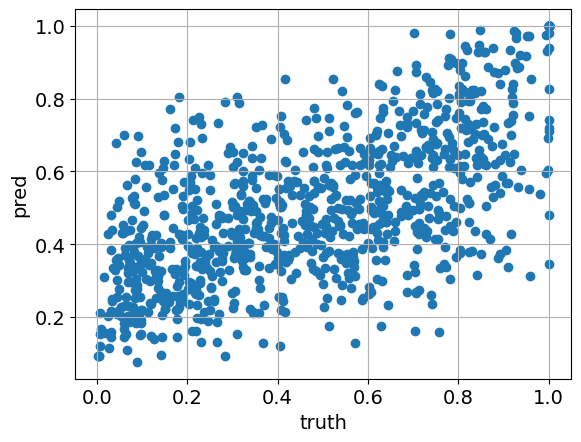

In [185]:
import matplotlib.pyplot as plt
plt.scatter(tanimotos_ms2, [s if s > 0 else 0 for s in scores_ms2], alpha=1)
plt.ylabel('pred')
plt.xlabel('truth')
plt.grid()

In [186]:
original_tanimotos_ms2 = tanimotos_ms2.copy()
original_scores_ms2=scores_ms2.copy()

In [187]:
tanimotos_ms2 = [t for t in tanimotos_ms2 if t is not None]
scores_ms2 = [t for t in scores_ms2 if t is not None]

In [188]:
tanimotos_ms2_binary= [1 if t>THRESHOLD_ANALOG else 0 for t in tanimotos_ms2]
scores_ms2=[s if s>0 else 0 for s in scores_ms2]

In [189]:
len(scores_ms2)

1000

In [190]:
sum(np.array(tanimotos_ms2_binary)>0)

297

In [191]:
np.sum((np.array(scores_ms2) > 0 )& (np.array(tanimotos_ms2_binary)>0))

297

tpr: [0.         0.16498316 0.28282828 0.28282828 0.3030303  0.3030303
 0.30639731 0.30639731 0.31313131 0.31313131 0.33333333 0.33333333
 0.34006734 0.34006734 0.37037037 0.37037037 0.37373737 0.37373737
 0.38047138 0.38047138 0.38720539 0.38720539 0.3973064  0.3973064
 0.4040404  0.4040404  0.41414141 0.41414141 0.41750842 0.41750842
 0.42760943 0.42760943 0.43434343 0.43434343 0.43771044 0.43771044
 0.44107744 0.44107744 0.46464646 0.46464646 0.47138047 0.47138047
 0.47474747 0.47474747 0.47811448 0.47811448 0.4983165  0.4983165
 0.5016835  0.5016835  0.50841751 0.50841751 0.51178451 0.51178451
 0.51515152 0.51515152 0.51851852 0.51851852 0.52525253 0.52525253
 0.52861953 0.52861953 0.53198653 0.53198653 0.54208754 0.54208754
 0.55218855 0.55218855 0.56228956 0.56228956 0.56565657 0.56565657
 0.57239057 0.57239057 0.58249158 0.58249158 0.58585859 0.58585859
 0.58922559 0.58922559 0.59259259 0.59259259 0.5993266  0.5993266
 0.61279461 0.61279461 0.61952862 0.61952862 0.62289562 0.622

(array([0.        , 0.16498316, 0.28282828, 0.28282828, 0.3030303 ,
        0.3030303 , 0.30639731, 0.30639731, 0.31313131, 0.31313131,
        0.33333333, 0.33333333, 0.34006734, 0.34006734, 0.37037037,
        0.37037037, 0.37373737, 0.37373737, 0.38047138, 0.38047138,
        0.38720539, 0.38720539, 0.3973064 , 0.3973064 , 0.4040404 ,
        0.4040404 , 0.41414141, 0.41414141, 0.41750842, 0.41750842,
        0.42760943, 0.42760943, 0.43434343, 0.43434343, 0.43771044,
        0.43771044, 0.44107744, 0.44107744, 0.46464646, 0.46464646,
        0.47138047, 0.47138047, 0.47474747, 0.47474747, 0.47811448,
        0.47811448, 0.4983165 , 0.4983165 , 0.5016835 , 0.5016835 ,
        0.50841751, 0.50841751, 0.51178451, 0.51178451, 0.51515152,
        0.51515152, 0.51851852, 0.51851852, 0.52525253, 0.52525253,
        0.52861953, 0.52861953, 0.53198653, 0.53198653, 0.54208754,
        0.54208754, 0.55218855, 0.55218855, 0.56228956, 0.56228956,
        0.56565657, 0.56565657, 0.57239057, 0.57

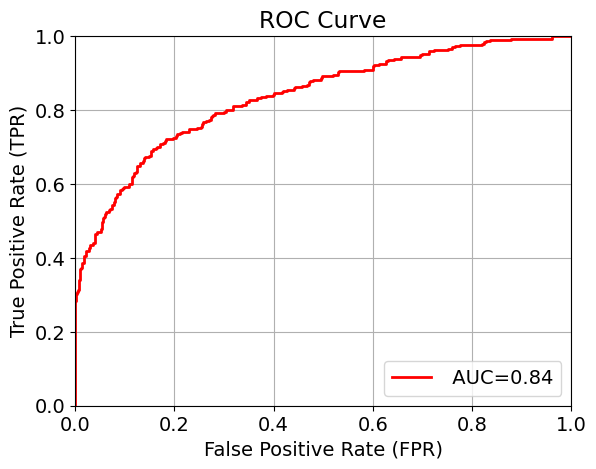

In [192]:

Plotting.plot_roc_curve(tanimotos_ms2_binary, scores_ms2)

In [193]:
a=5

In [194]:
spearman_ms2 = spearmanr(tanimotos_ms2, scores_ms2)

## Our model

In [104]:
from src.transformers.sklearn_model import SklearnModel

In [105]:
#temp_molecule_pairs= MolecularPairsSet(spectrums= molecule_pairs.spectrums, 
#                                      indexes_tani =molecule_pairs.indexes_tani)
temp_molecule_pairs = molecule_pairs

In [106]:
#model = Embedder.load_from_checkpoint(
 #           checkpoint_path=transformer_path, d_model=config.D_MODEL, n_layers=config.N_LAYERS
#        )

In [107]:
model =SklearnModel(model_path=transformer_path, d_model=config.D_MODEL, n_layers=config.N_LAYERS)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Using cosine library from Pytorch?: True


In [108]:
#next(iter(dataloader_test))

In [109]:
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] 

'1'

In [164]:
scores_trans=model.predict_from_molecule_pair(temp_molecule_pairs)

Preprocessing all the data ...



0it [00:00, ?it/s]
4048it [00:00, 40476.76it/s]
12848it [00:00, 68427.56it/s]
21713it [00:00, 77660.00it/s]
33719it [00:00, 77157.74it/s]


Finished preprocessing 
loading data
Normalizing intensities
Creating dictionaries



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40940/40940 [00:00<00:00, 106796.78it/s]


Preprocessing all the data ...



0it [00:00, ?it/s]
4277it [00:00, 42768.41it/s]
12954it [00:00, 68649.61it/s]
21706it [00:00, 77261.78it/s]
33719it [00:00, 76582.09it/s]


Finished preprocessing 
loading data
Normalizing intensities
Creating dictionaries


Predicting: |                                                                                                 …

In [168]:
temp_molecule_pairs

In [169]:
tanimoto_trans = [row[2] for row in temp_molecule_pairs.indexes_tani]

In [170]:
tanimoto_trans_binary=[1 if t>THRESHOLD_ANALOG else 0 for t in tanimoto_trans]
scores_trans=[float(s) if s>0 else 0 for s in (scores_trans)]

In [171]:
scores_trans

[0.0220511294901371,
 0.3267439603805542,
 0.022218890488147736,
 0.04170221835374832,
 0.0662468895316124,
 0.04249235987663269,
 0.5316166877746582,
 0.06592954695224762,
 0.18880054354667664,
 0.0361362062394619,
 0.05159309133887291,
 0.03777217119932175,
 0.08399464190006256,
 0.04262411594390869,
 0.12208476662635803,
 0.040286511182785034,
 0.020125651732087135,
 0.13295823335647583,
 0.037205711007118225,
 0.03942325338721275,
 0.04085530340671539,
 0.06535588204860687,
 0.040180571377277374,
 0.05421102046966553,
 0.11823342740535736,
 0.139863982796669,
 0.03598964959383011,
 0.08787716925144196,
 0.0243094339966774,
 0.05856599658727646,
 0.10746262967586517,
 0.15846413373947144,
 0.08603312075138092,
 0.03760487213730812,
 0.09798040241003036,
 0.04505614563822746,
 0.08143050223588943,
 0.5232492089271545,
 0.07813096046447754,
 0.292016863822937,
 0.04558886960148811,
 0.05581203103065491,
 0.06913438439369202,
 0.032797008752822876,
 0.03215545043349266,
 0.069076716899

In [172]:
tanimoto_trans

[0.07105263322591782,
 0.05461393669247627,
 0.033175356686115265,
 0.07692307978868484,
 0.06821107119321823,
 0.08255814015865326,
 0.050314463675022125,
 0.059957172721624374,
 0.09568261355161667,
 0.06172839552164078,
 0.04026845470070839,
 0.06145251542329788,
 0.0859375,
 0.03773584961891174,
 0.07674943655729294,
 0.05128205195069313,
 0.019607843831181526,
 0.07226354628801346,
 0.09502924233675003,
 0.048192769289016724,
 0.06205250695347786,
 0.04297994449734688,
 0.08389262109994888,
 0.04249291867017746,
 0.07920791953802109,
 0.08743169158697128,
 0.07248321920633316,
 0.08985024690628052,
 0.09812286496162415,
 0.0390625,
 0.02179836481809616,
 0.07479224354028702,
 0.05749128758907318,
 0.054054055362939835,
 0.07154212892055511,
 0.051936618983745575,
 0.08753567934036255,
 0.08160000294446945,
 0.09375,
 0.07446808367967606,
 0.0810810774564743,
 0.06706114113330841,
 0.0714285746216774,
 0.00455580884590745,
 0.013353115878999233,
 0.06646525859832764,
 0.05711318925

In [173]:
len(tanimoto_trans)

40940

In [174]:
len(scores_trans)

40940

In [175]:
spearman_trans = spearmanr(tanimoto_trans, scores_trans)
spearman_trans

SignificanceResult(statistic=0.9054398838913401, pvalue=0.0)

In [176]:
np.sum((np.array(scores_trans) > 0 )& (np.array(tanimoto_trans_binary)>0))

12282

tpr: [0.         0.0012213  0.00724638 ... 0.99991858 1.         1.        ]
fpr: [0.         0.         0.         ... 0.98750785 0.98750785 1.        ]


(array([0.        , 0.0012213 , 0.00724638, ..., 0.99991858, 1.        ,
        1.        ]),
 array([0.        , 0.        , 0.        , ..., 0.98750785, 0.98750785,
        1.        ]))

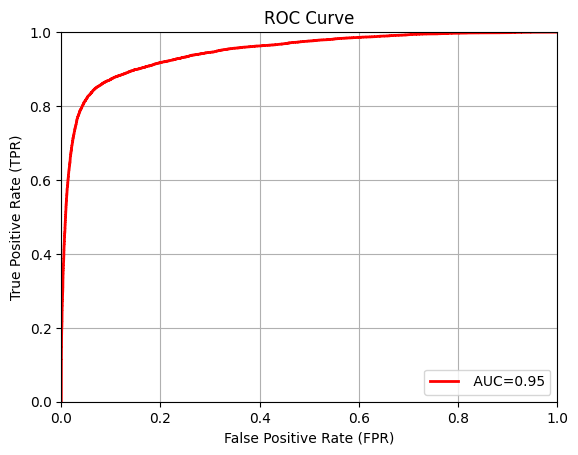

In [177]:
Plotting.plot_roc_curve(tanimoto_trans_binary, scores_trans)

## Plot all results

In [178]:
sum(tanimoto_spec2vec_binary)

7882

tpr: [0.         0.15072317 0.15097691 ... 0.94912459 0.94912459 1.        ]
fpr: [0.         0.         0.         ... 0.76254268 0.76260835 1.        ]
tpr: [0.         0.16666667 0.33333333 0.33333333 0.4        0.4
 0.5        0.5        0.53333333 0.53333333 0.56666667 0.56666667
 0.66666667 0.66666667 0.73333333 0.73333333 0.76666667 0.76666667
 0.8        0.8        0.83333333 0.83333333 0.86666667 0.86666667
 0.9        0.9        0.93333333 0.93333333 0.96666667 0.96666667
 1.         1.        ]
fpr: [0.         0.         0.         0.01428571 0.01428571 0.04285714
 0.04285714 0.07142857 0.07142857 0.08571429 0.08571429 0.17142857
 0.17142857 0.18571429 0.18571429 0.2        0.2        0.22857143
 0.22857143 0.35714286 0.35714286 0.4        0.4        0.6
 0.6        0.64285714 0.64285714 0.68571429 0.68571429 0.87142857
 0.87142857 1.        ]
tpr: [0.         0.0012213  0.00724638 ... 0.99991858 1.         1.        ]
fpr: [0.         0.         0.         ... 0.98750785 0

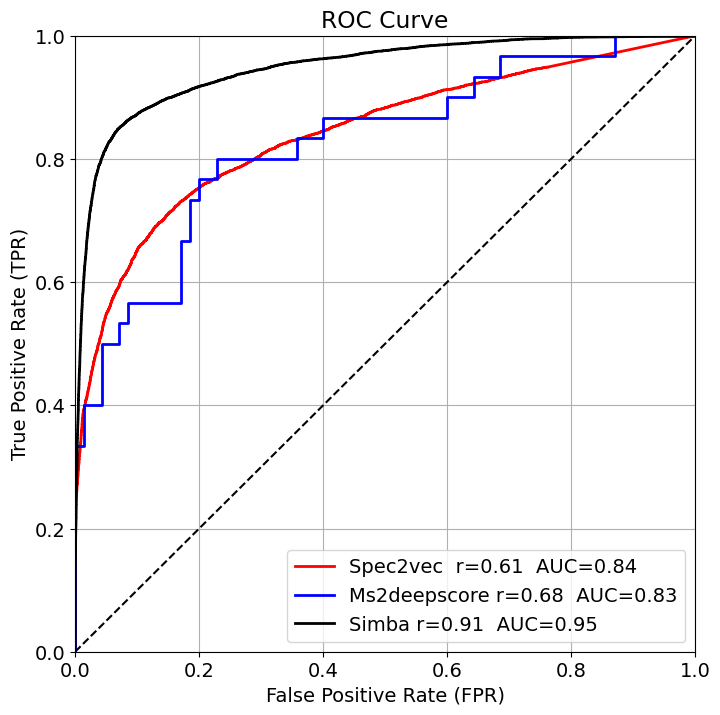

In [179]:
Plotting.plot_n_roc_curves(y_true_list= [tanimoto_spec2vec_binary, tanimotos_ms2_binary, tanimoto_trans_binary],
                           y_scores_list=[scores_spec2vec, scores_ms2, scores_trans],
                           labels=[f'Spec2vec  r={spearman_spec2vec[0]:.2f} ', 
                                   f'Ms2deepscore r={spearman_ms2[0]:.2f} ', 
                                   f'Simba r={spearman_trans[0]:.2f} '],
                           colors = ['r','b','k'])

## Save data

In [ ]:
## save spectrums to analyze
#with open('./spectrums_sent.pkl', 'wb') as f:
#    pickle.dump(original_spectrum_match_hash, f)

In [ ]:
#pairs = []
#for m in tqdm(molecule_pairs):
#            hash_0 = m.spectrum_object_0.spectrum_hash
#            hash_1 = m.spectrum_object_1.spectrum_hash

#            # get right spectra
#            index_0 = target_hashes_subset.index(hash_0)
#            index_1 = target_hashes_subset.index(hash_1)
#            pairs.append((index_0, index_1))

In [ ]:
## save pairs

In [ ]:
## save spectrums to analyze
#with open('./pairs_indexes.pkl', 'wb') as f:
#    pickle.dump(pairs, f)

## Compute modified cosine

In [77]:
from src.modified_cosine import ModCosine

In [78]:
modcos_similarity =ModCosine.get_mod_cosine()

In [80]:
tanimoto_modcos, scores_modcos= ModCosine.compute_scores_tanimoto(molecule_pairs, 
                                                                                preprocessed_spectrums, 
                                                                               target_hashes_subset, 
                                                                               modcos_similarity)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40940/40940 [00:06<00:00, 6807.39it/s]


In [81]:
original_tanimoto_modcos = tanimoto_modcos.copy()
original_scores_modcos=scores_modcos.copy()

In [82]:
tanimoto_modcos = [t for t in tanimoto_modcos if t is not None]
scores_modcos = [t for t in scores_modcos if t is not None]

In [83]:
len(scores_modcos)

23110

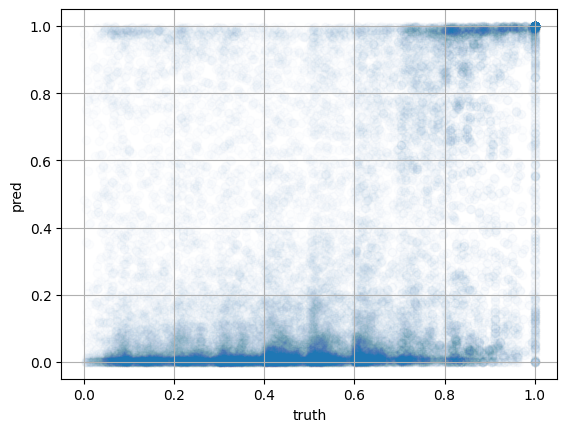

In [84]:
import matplotlib.pyplot as plt
plt.scatter(tanimoto_modcos, scores_modcos, alpha=0.01)
plt.ylabel('pred')
plt.xlabel('truth')
plt.grid()

In [85]:
tanimoto_modcos_binary=[1 if t>THRESHOLD_ANALOG else 0 for t in tanimoto_modcos]
scores_modcos= [s if s>0 else 0 for s in scores_modcos ]

tpr: [0.00000000e+00 1.26871352e-04 6.34356762e-04 ... 9.91626491e-01
 9.91626491e-01 1.00000000e+00]
fpr: [0.         0.         0.         ... 0.96657473 0.96716575 1.        ]


(array([0.00000000e+00, 1.26871352e-04, 6.34356762e-04, ...,
        9.91626491e-01, 9.91626491e-01, 1.00000000e+00]),
 array([0.        , 0.        , 0.        , ..., 0.96657473, 0.96716575,
        1.        ]))

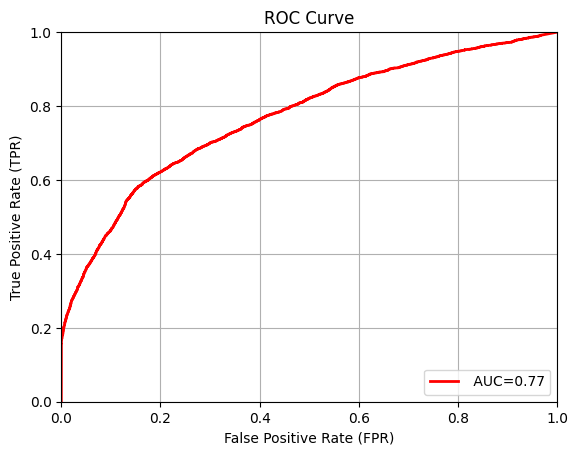

In [86]:
Plotting.plot_roc_curve(tanimoto_modcos_binary,scores_modcos)

In [87]:
len(scores_modcos)

23110

In [88]:
spearman_modcos = spearmanr(tanimoto_modcos, scores_modcos)

tpr: [0.         0.0012213  0.00724638 ... 0.99991858 1.         1.        ]
fpr: [0.         0.         0.         ... 0.98750785 0.98750785 1.        ]
tpr: [0.         0.16498316 0.28282828 0.28282828 0.3030303  0.3030303
 0.30639731 0.30639731 0.31313131 0.31313131 0.33333333 0.33333333
 0.34006734 0.34006734 0.37037037 0.37037037 0.37373737 0.37373737
 0.38047138 0.38047138 0.38720539 0.38720539 0.3973064  0.3973064
 0.4040404  0.4040404  0.41414141 0.41414141 0.41750842 0.41750842
 0.42760943 0.42760943 0.43434343 0.43434343 0.43771044 0.43771044
 0.44107744 0.44107744 0.46464646 0.46464646 0.47138047 0.47138047
 0.47474747 0.47474747 0.47811448 0.47811448 0.4983165  0.4983165
 0.5016835  0.5016835  0.50841751 0.50841751 0.51178451 0.51178451
 0.51515152 0.51515152 0.51851852 0.51851852 0.52525253 0.52525253
 0.52861953 0.52861953 0.53198653 0.53198653 0.54208754 0.54208754
 0.55218855 0.55218855 0.56228956 0.56228956 0.56565657 0.56565657
 0.57239057 0.57239057 0.58249158 0.5824

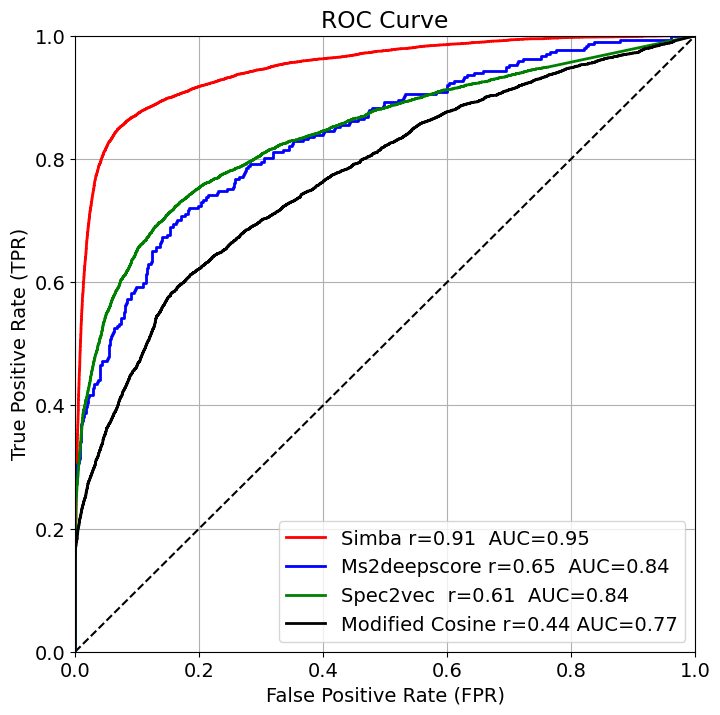

In [195]:
Plotting.plot_n_roc_curves(y_true_list= [tanimoto_trans_binary, tanimotos_ms2_binary, tanimoto_spec2vec_binary,  tanimoto_modcos_binary, ],
                           y_scores_list=[scores_trans, scores_ms2, scores_spec2vec, scores_modcos, ],
                           labels=[f'Simba r={spearman_trans[0]:.2f} ',
                                   f'Ms2deepscore r={spearman_ms2[0]:.2f} ', 
                                   f'Spec2vec  r={spearman_spec2vec[0]:.2f} ', 
                                   F'Modified Cosine r={spearman_modcos[0]:.2f}'],
                                   
                           colors = ['r','b','g', 'k'])
plt.grid()

##  Test on Janssen data

##  Save comparison

In [ ]:
len(original_tanimoto_modcos)

In [ ]:
original_scores_modcos

In [ ]:
tanimoto_trans

In [ ]:
scores_trans

In [ ]:
smiles = [(m.smiles_0, m.smiles_1) for m in molecule_pairs]

In [ ]:
from rdkit import Chem

In [ ]:
smiles = [(Chem.CanonSmiles(s[0]),Chem.CanonSmiles(s[1])) for s in smiles]

In [ ]:
results= [(s[0],s[1],t, modcos, simba, ) for s,t,modcos,simba,  in zip(smiles, tanimoto_trans, original_scores_modcos, scores_trans)]

In [ ]:
results = [r for r in results if r[3] is not None]

In [ ]:
len(results)

In [ ]:
# Define the file path
file_path = 'comparison_table.txt'

# Open the file in write mode
with open(file_path, 'w') as file:
    # Iterate over the list of tuples
    file.write(f'smiles1, smiles2,tanimoto, mod_cosine, simba,\n')
    for tuple_item in results:
        # Convert the tuple to a string and write it as a line in the file
        file.write(f'{tuple_item[0]}, {tuple_item[1]},{tuple_item[2]}, {tuple_item[3]},{tuple_item[4]},\n')

In [ ]:
Plotting.plot_n_roc_curves(y_true_list= [tanimoto_modcos, tanimoto_trans_binary],
                           y_scores_list=[scores_modcos, scores_trans],
                           labels=[f'Spec2vec  r={spearman_spec2vec[0]:.2f} ', 
                                   f'Ms2deepscore r={spearman_ms2[0]:.2f} ', 
                                   f'Simba'],
                           colors = ['r','b','k'])